# Set-up notebook environment
## NOTE: Use Songbird Kernel

In [1]:
import os
import biom
import warnings
import numpy as np
import pandas as pd
import qiime2 as q2
from biom import Table
from assets.util import add_taxsplit
from skbio import OrdinationResults
from qiime2.plugins.songbird.actions import multinomial, summarize_paired
from qiime2.plugins.emperor.actions import biplot

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from upsetplot import UpSet
from upsetplot import generate_counts, plot
from upsetplot import from_memberships
from matplotlib_venn import venn2
from matplotlib_venn import (venn3, venn3_circles,
                             venn2_circles)

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.style.use('ggplot')
plt.style.use('tableau-colorblind10')
paper_rc = {'lines.markersize': 5}                  
sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

%matplotlib inline


In [2]:
def format_uplot(df):
    df_binary = (df > 0.0).rename(columns=lambda x: x + '>0')
    df = pd.concat([df, df_binary], axis=1)
    index_ = df.index
    df = df.set_index(list(df_binary.columns))
    df['taxa'] = index_
    return df


phylum


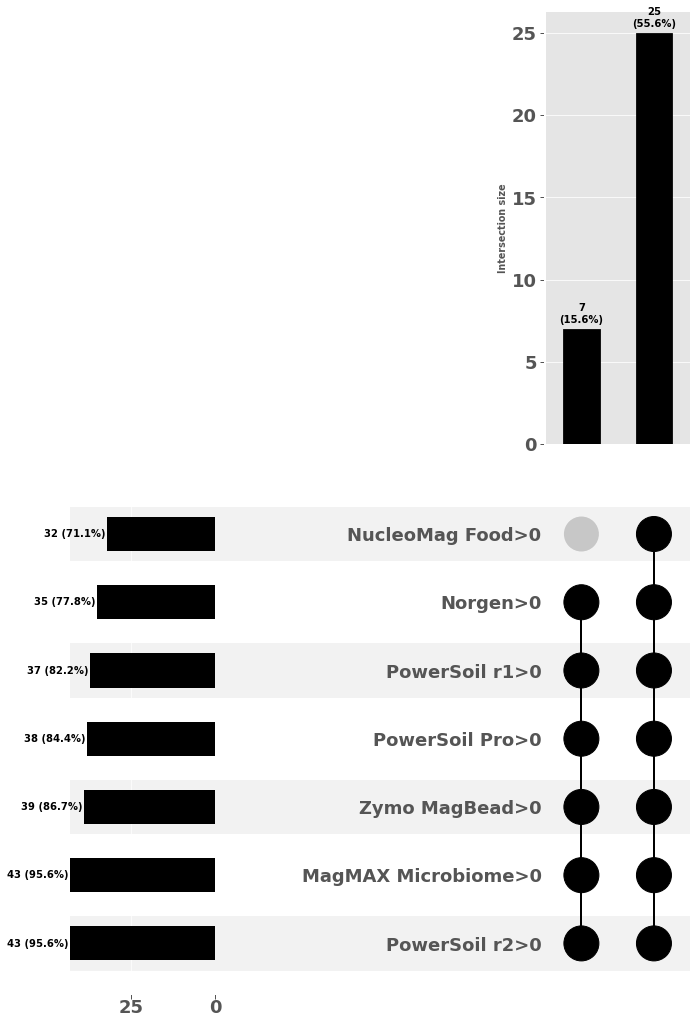

class


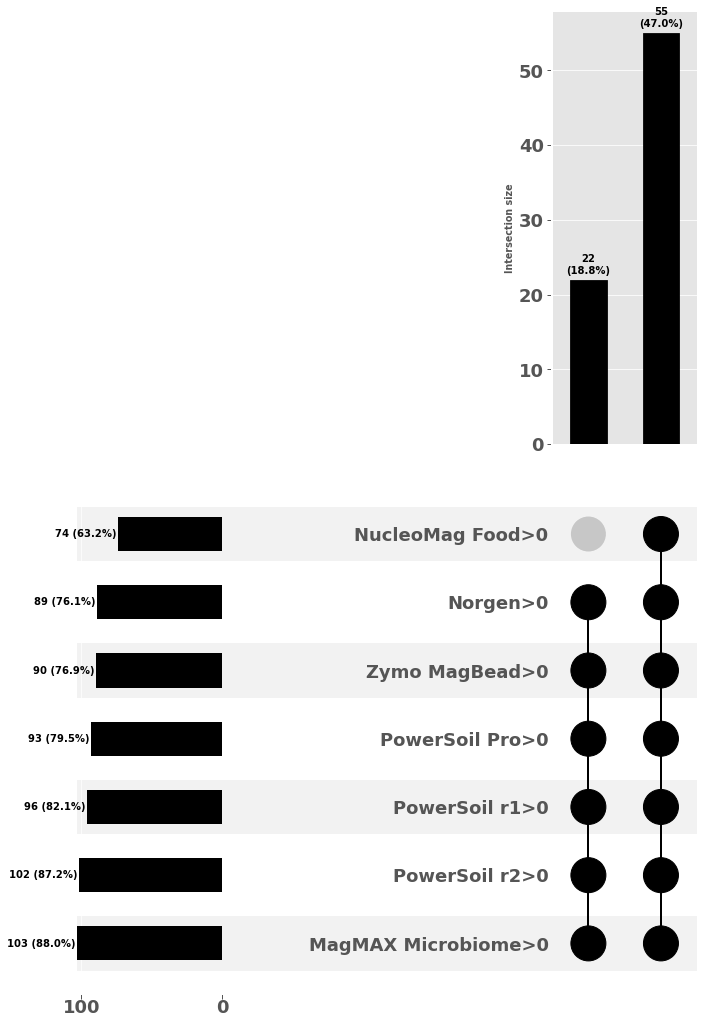

order


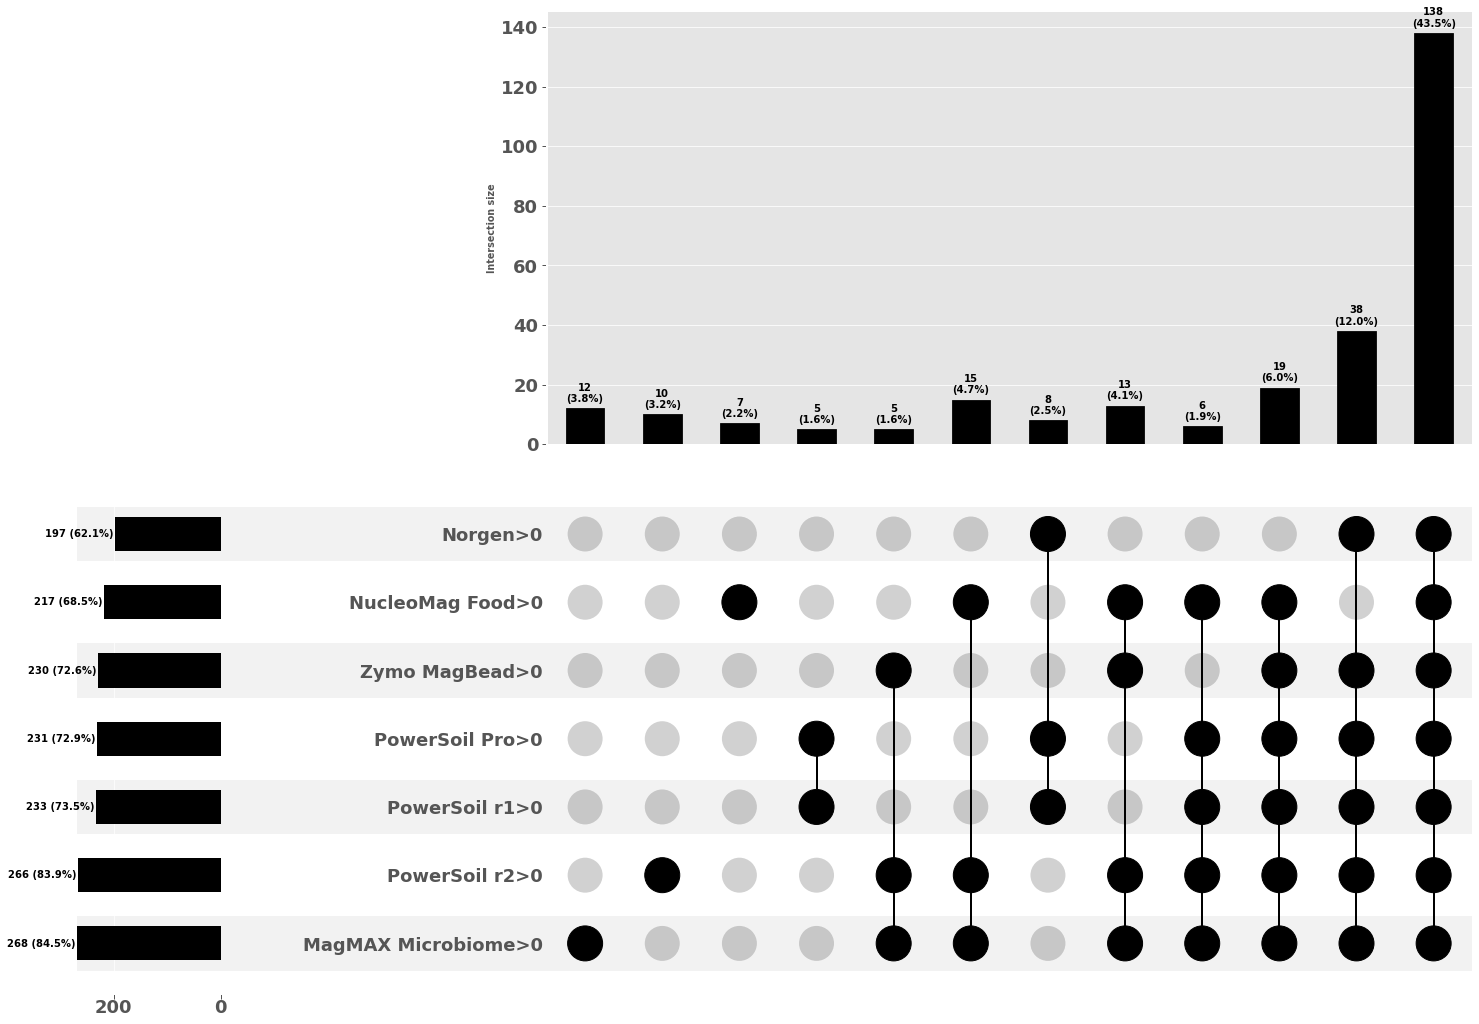

family


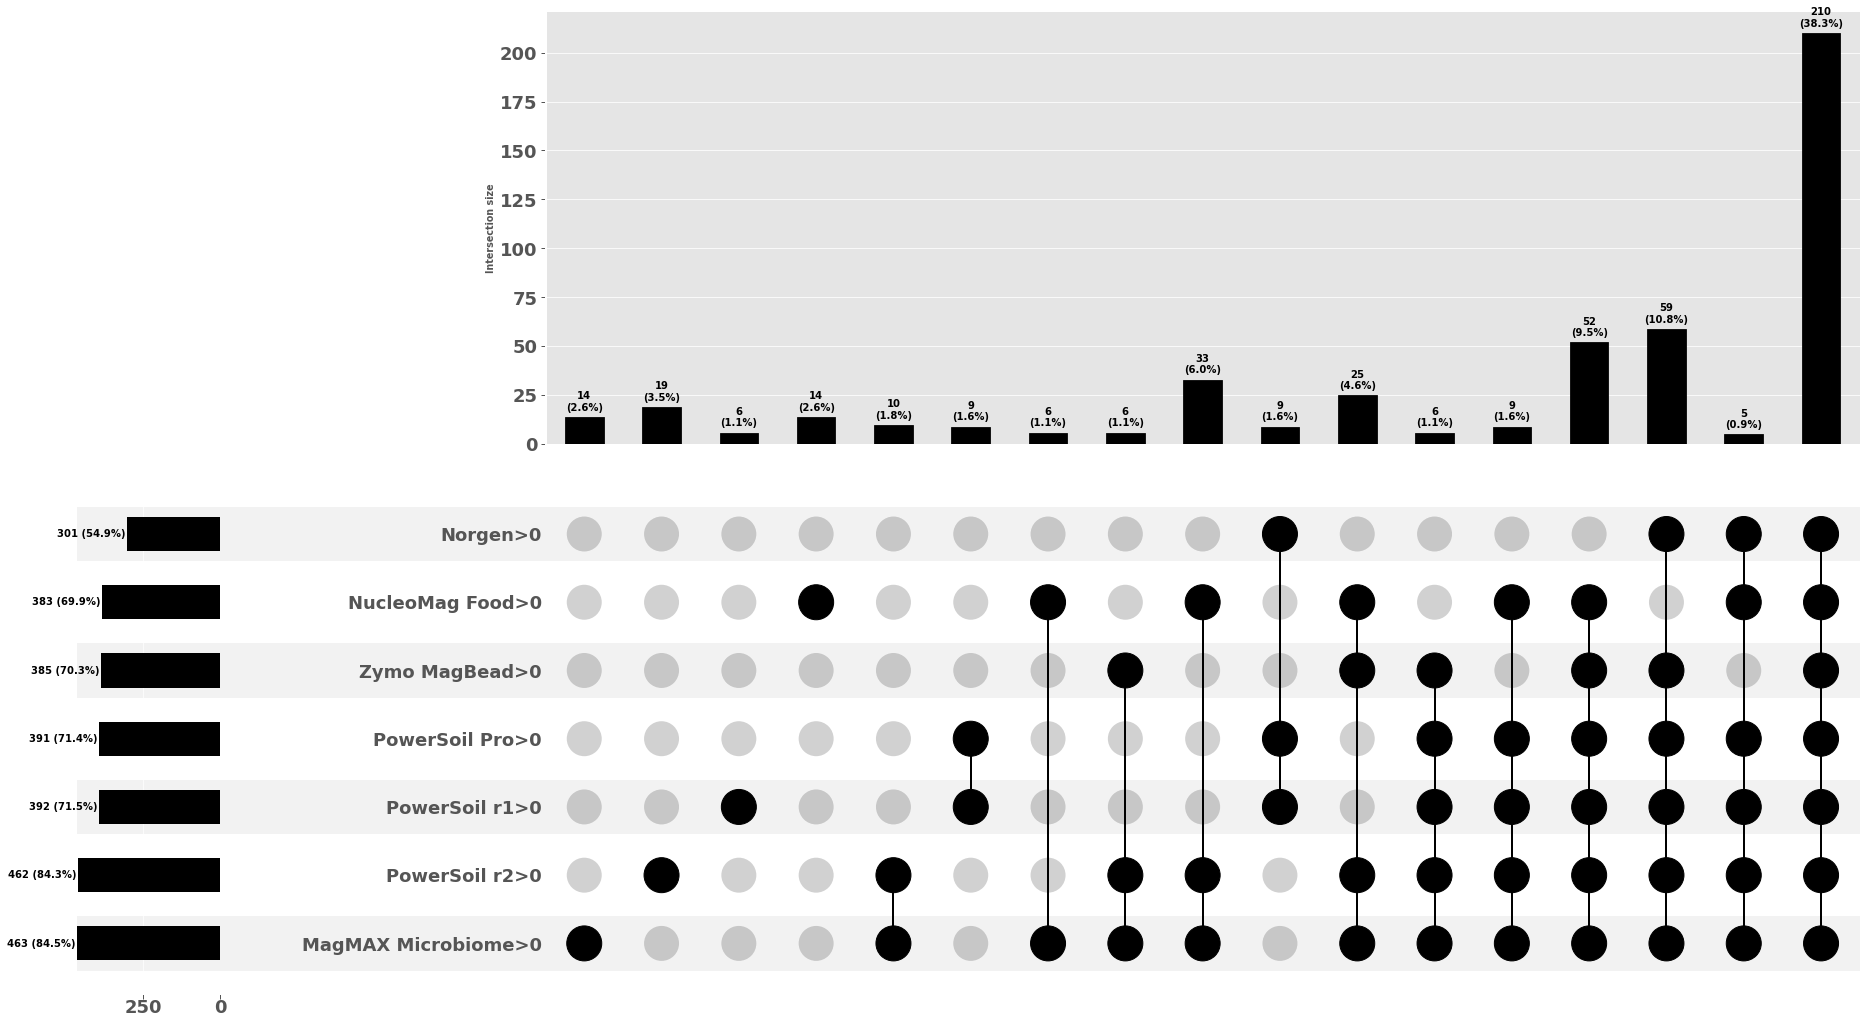

genus


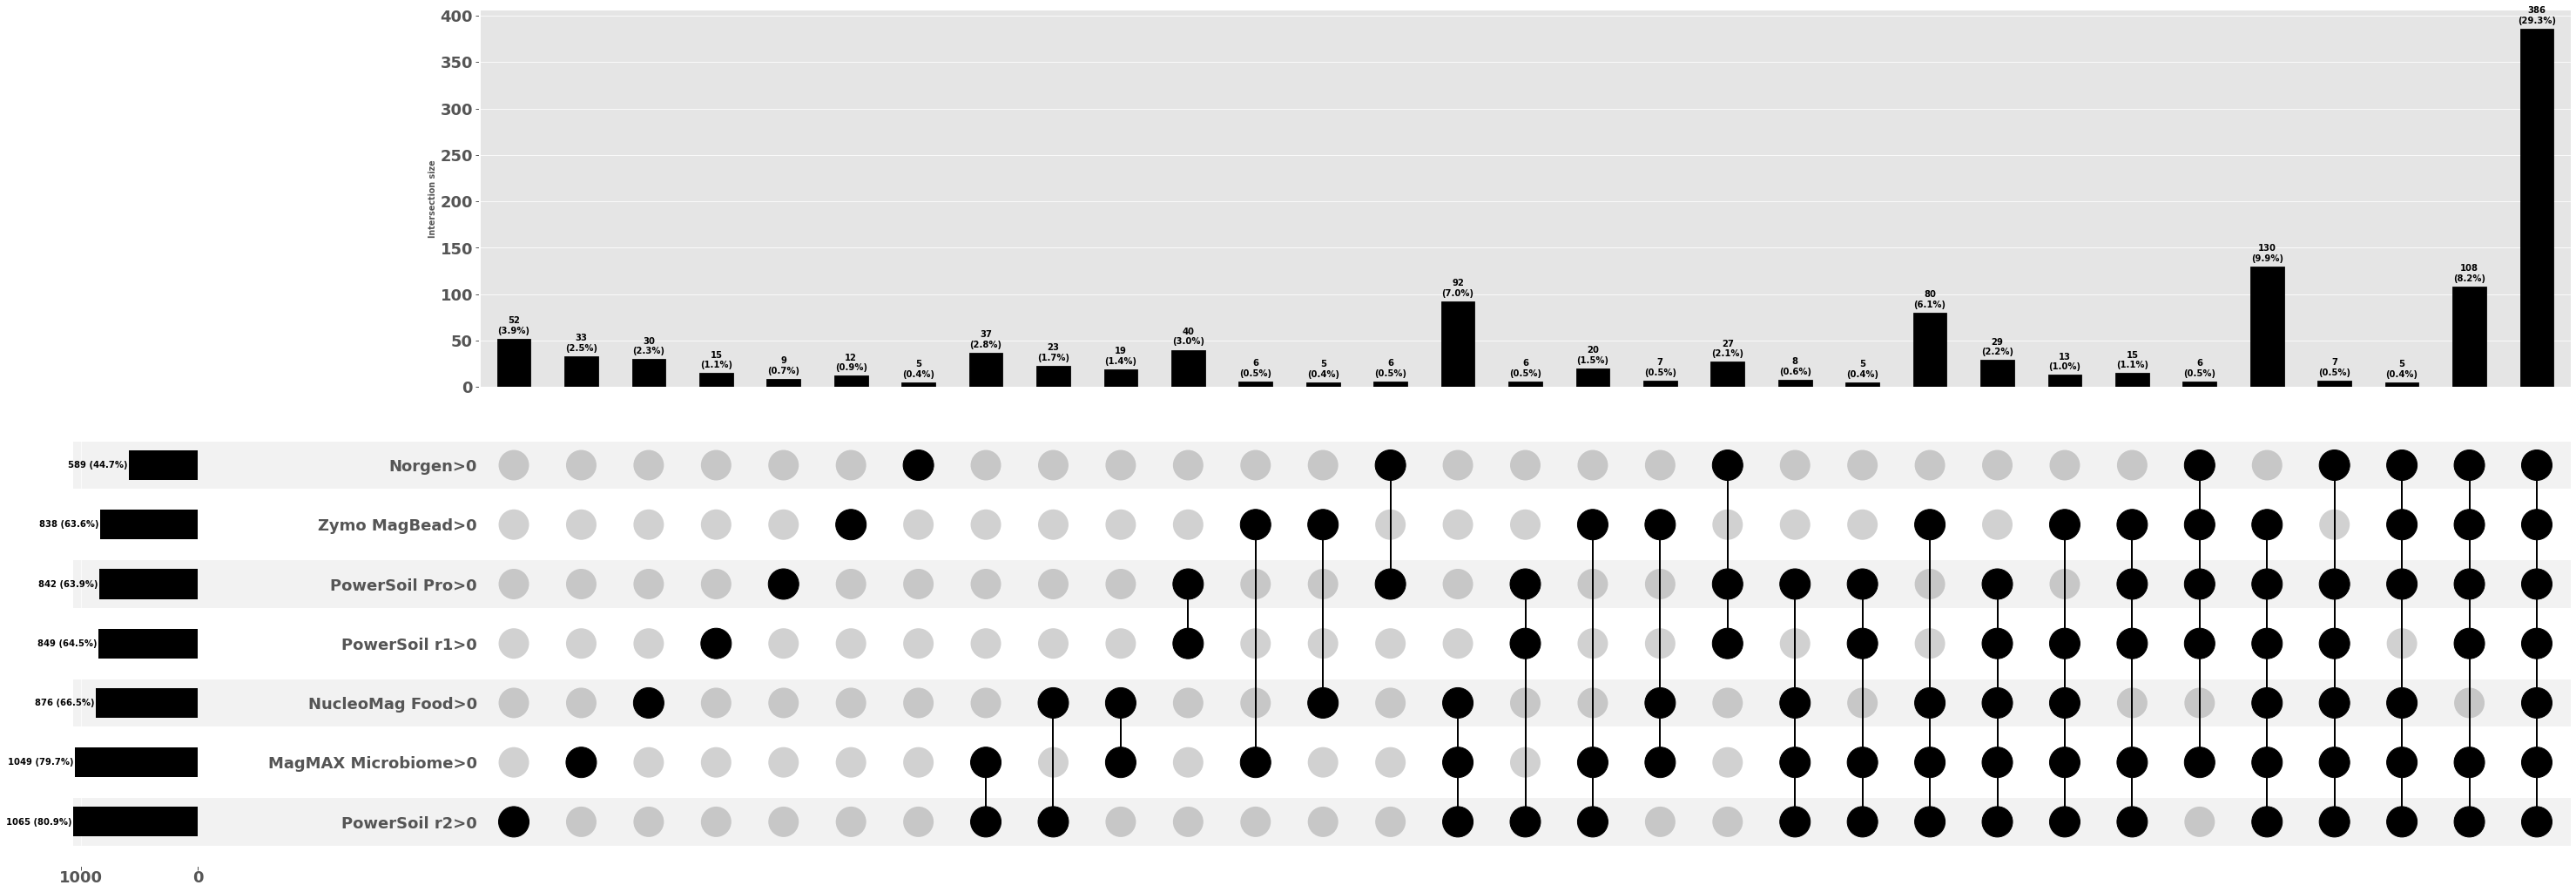

species


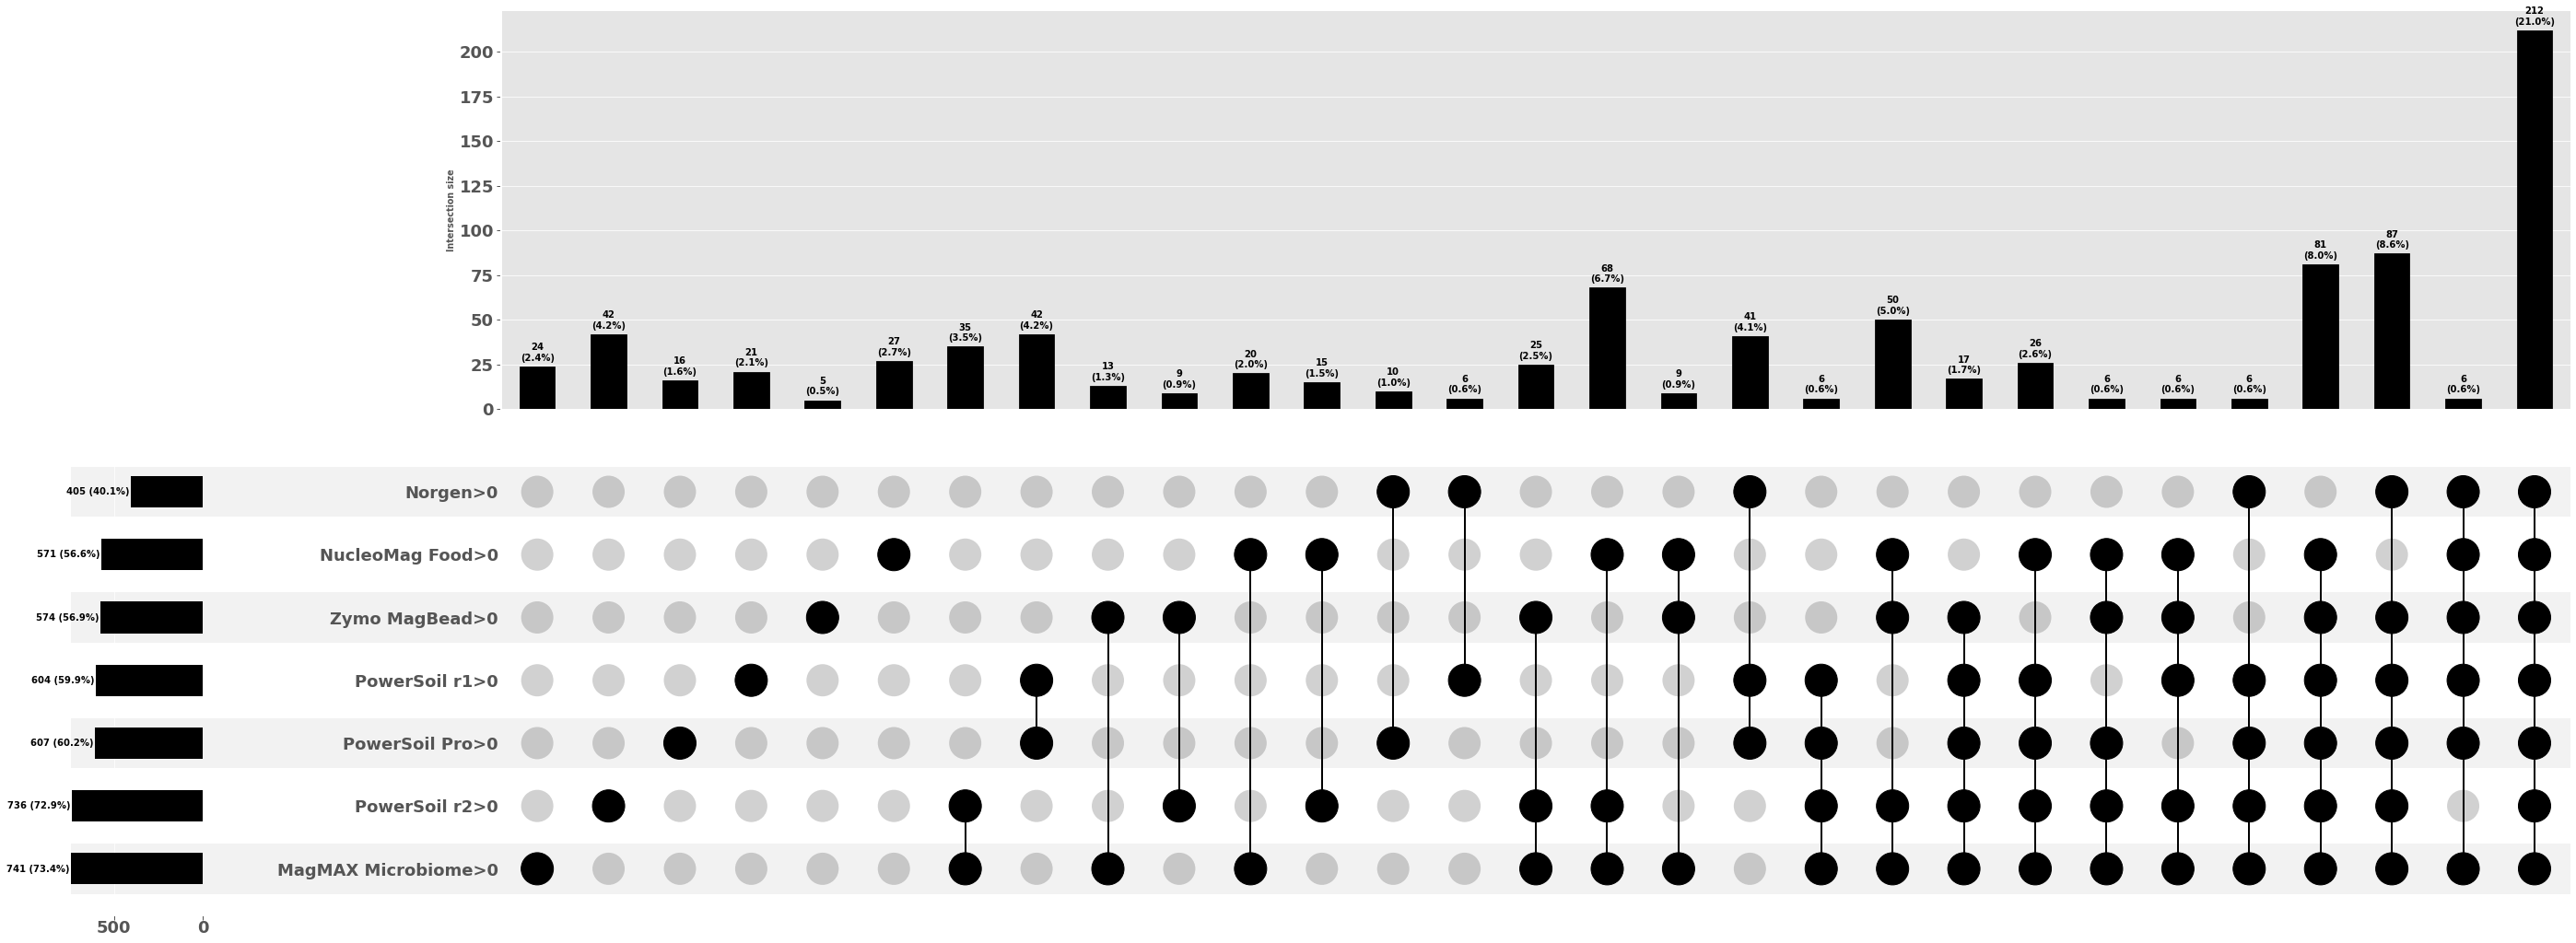

phylum


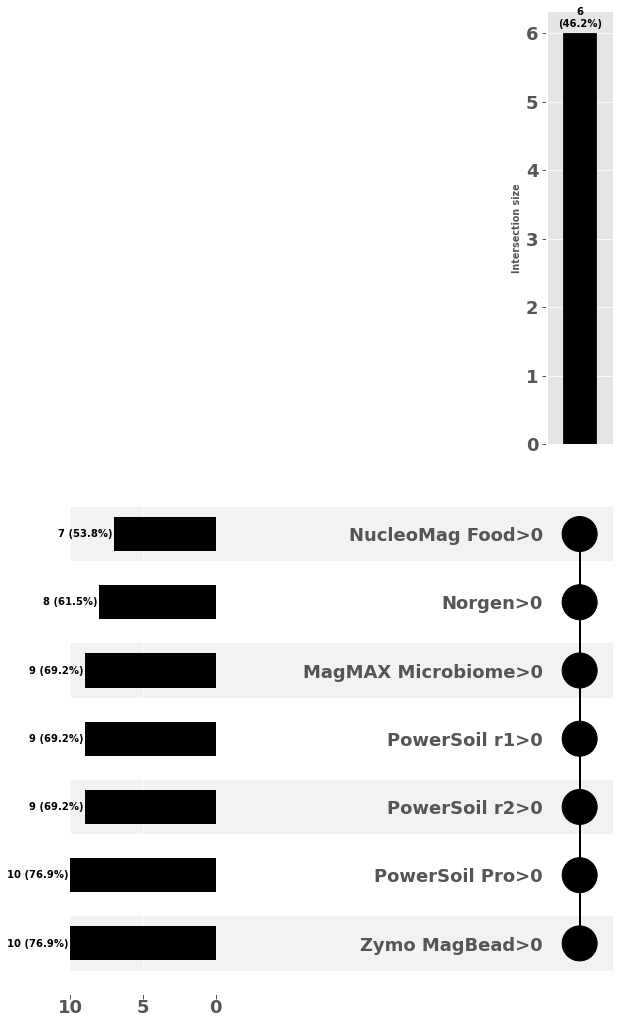

class


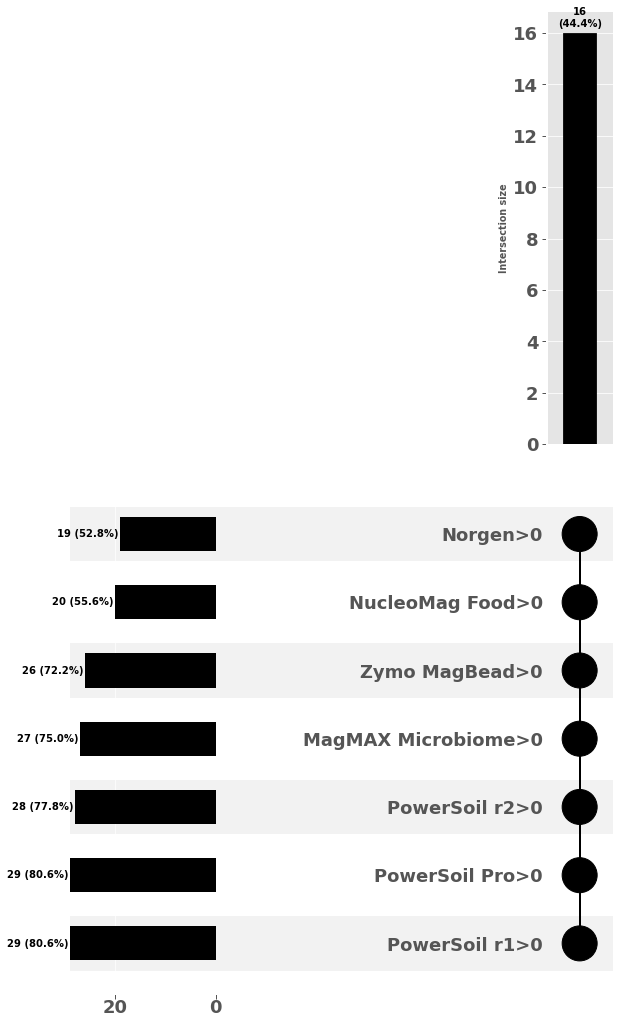

order


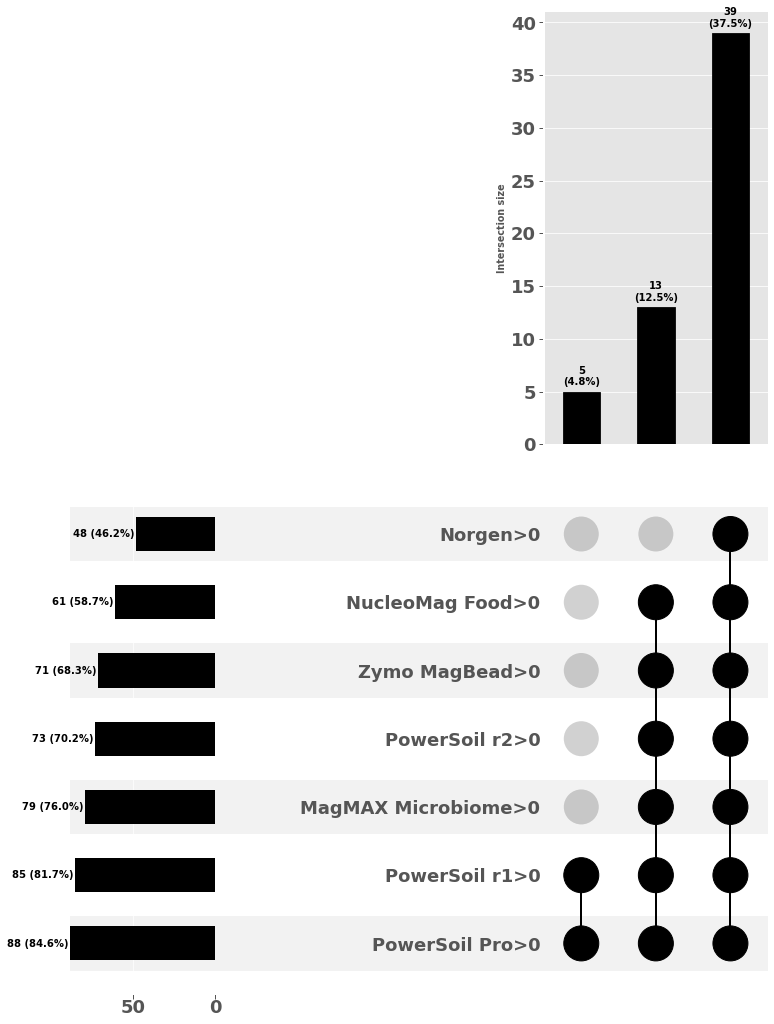

family


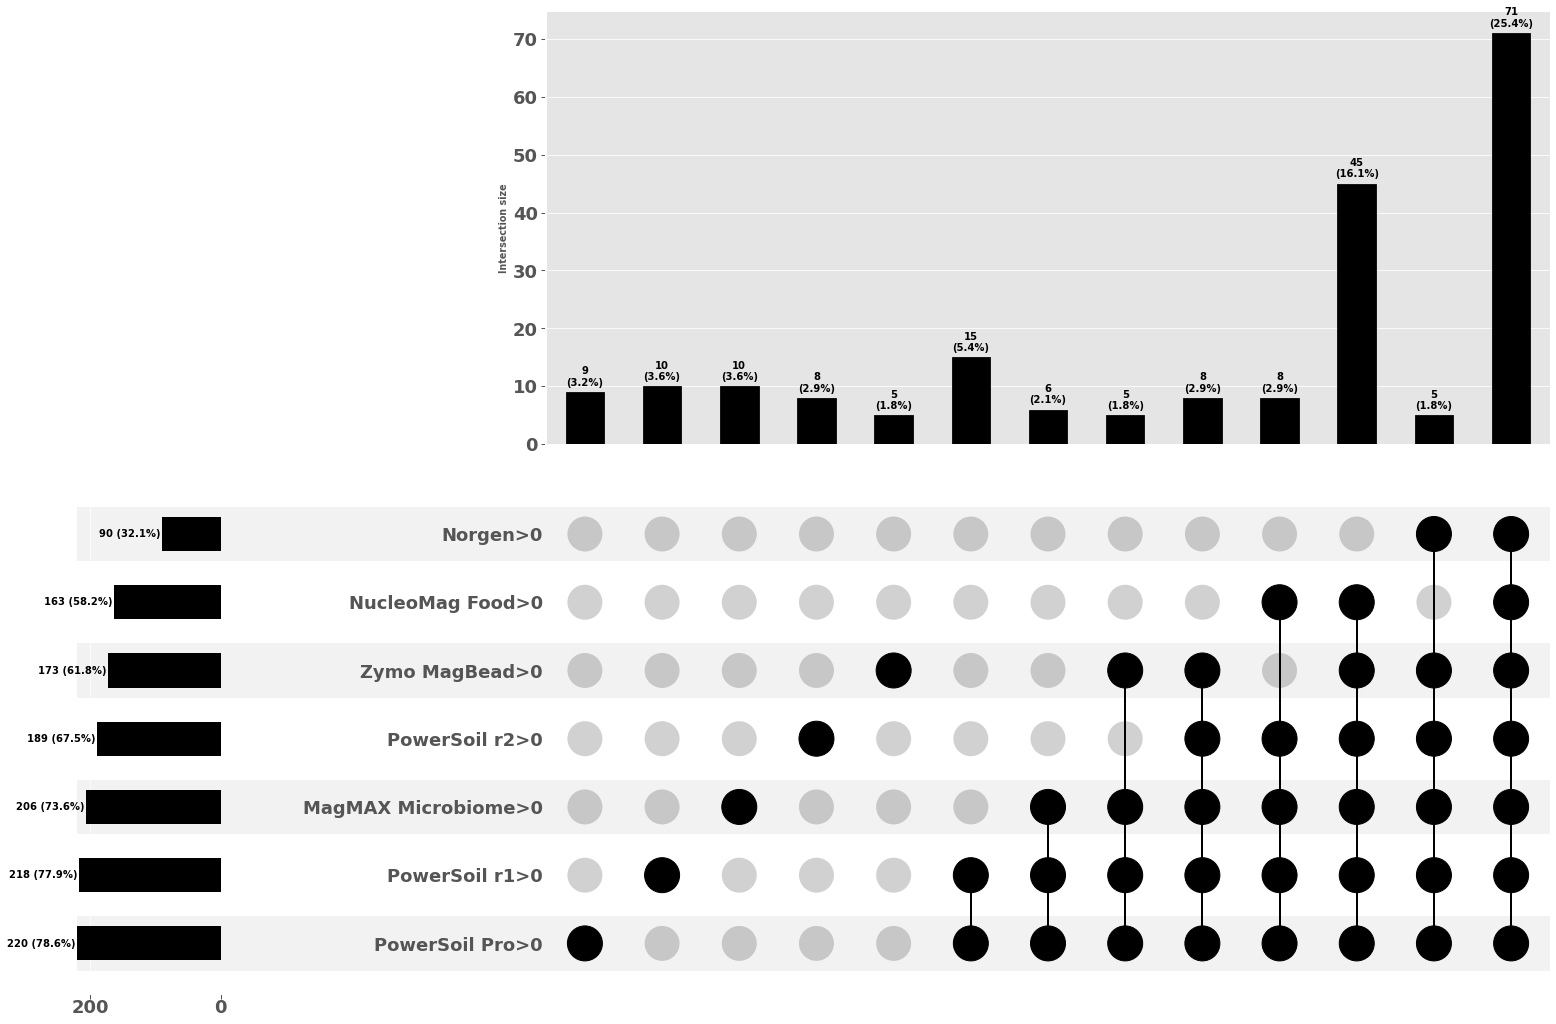

genus


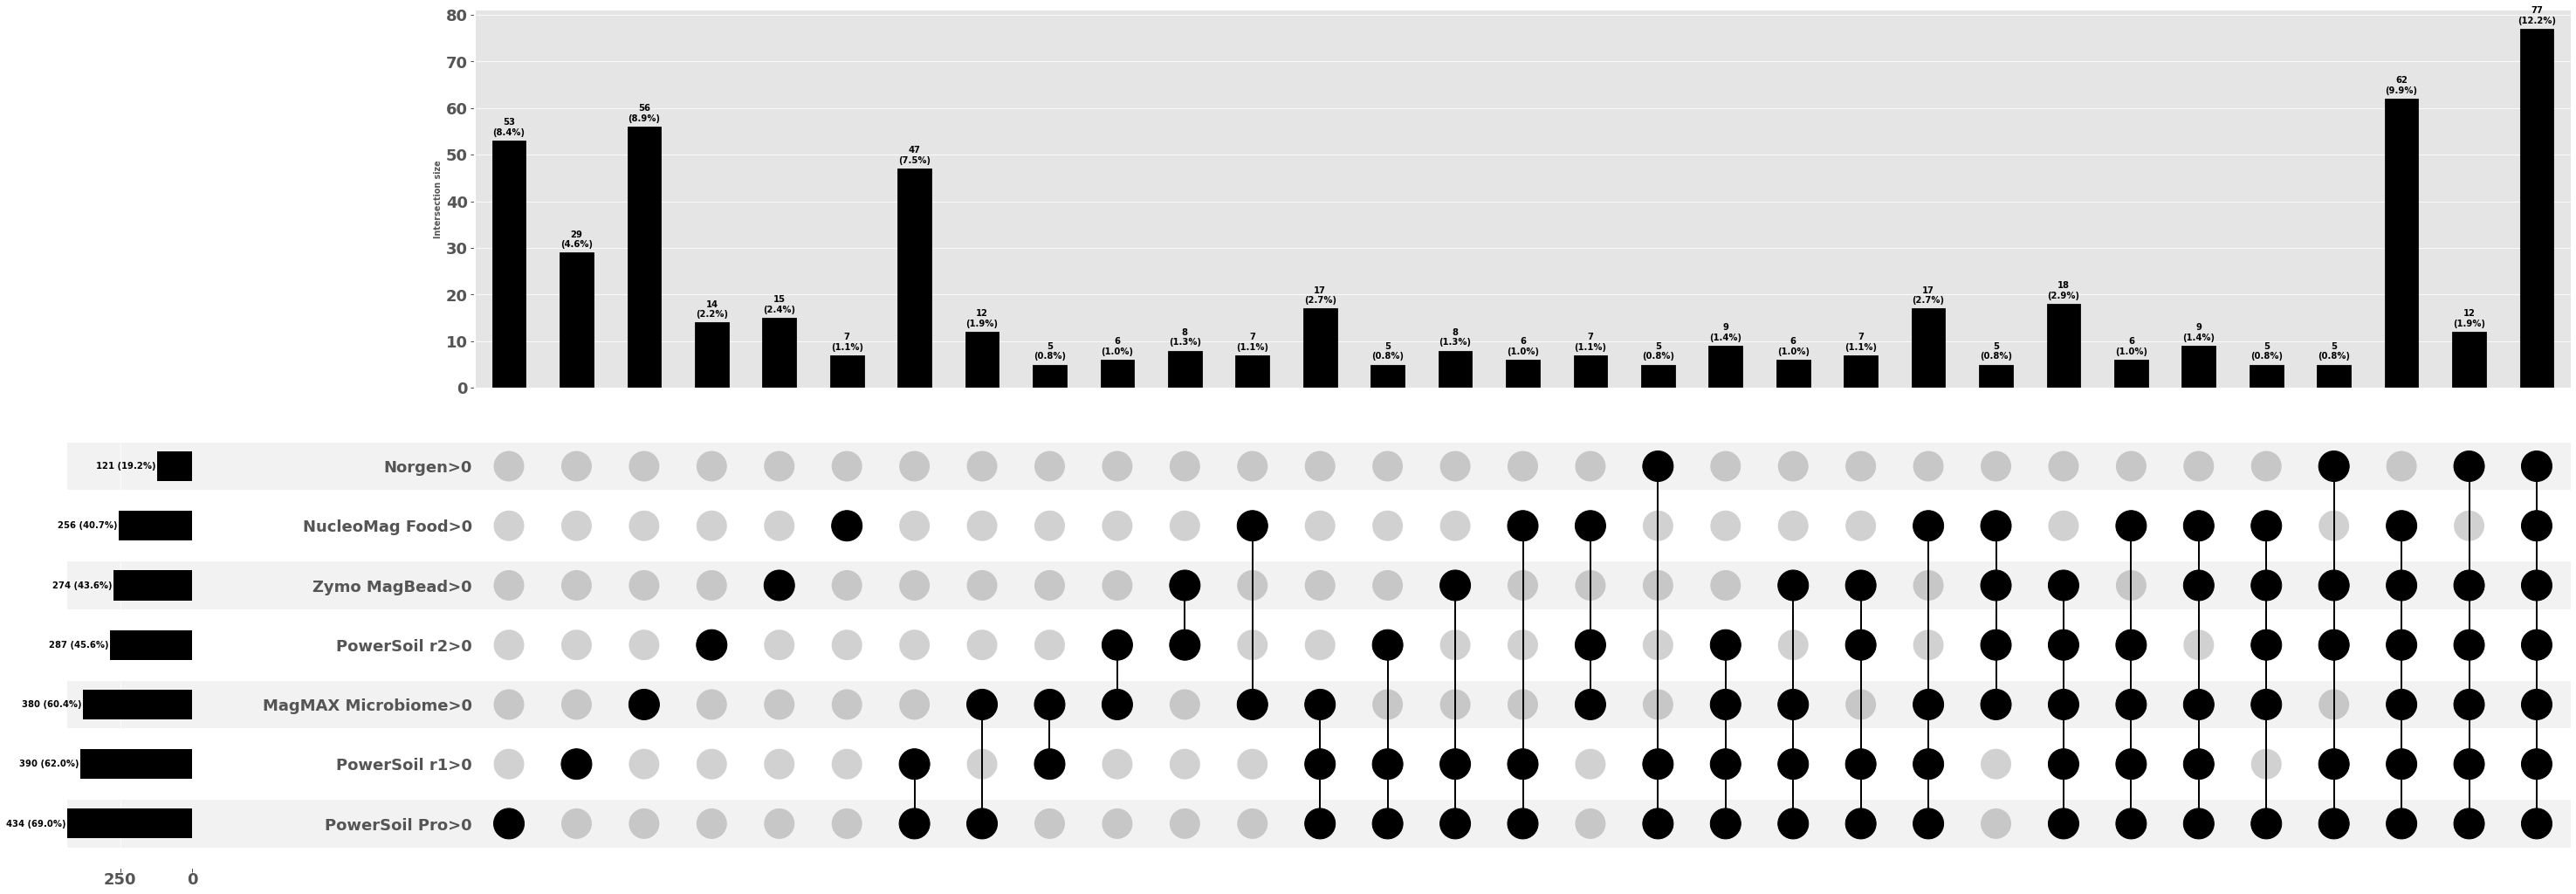

species


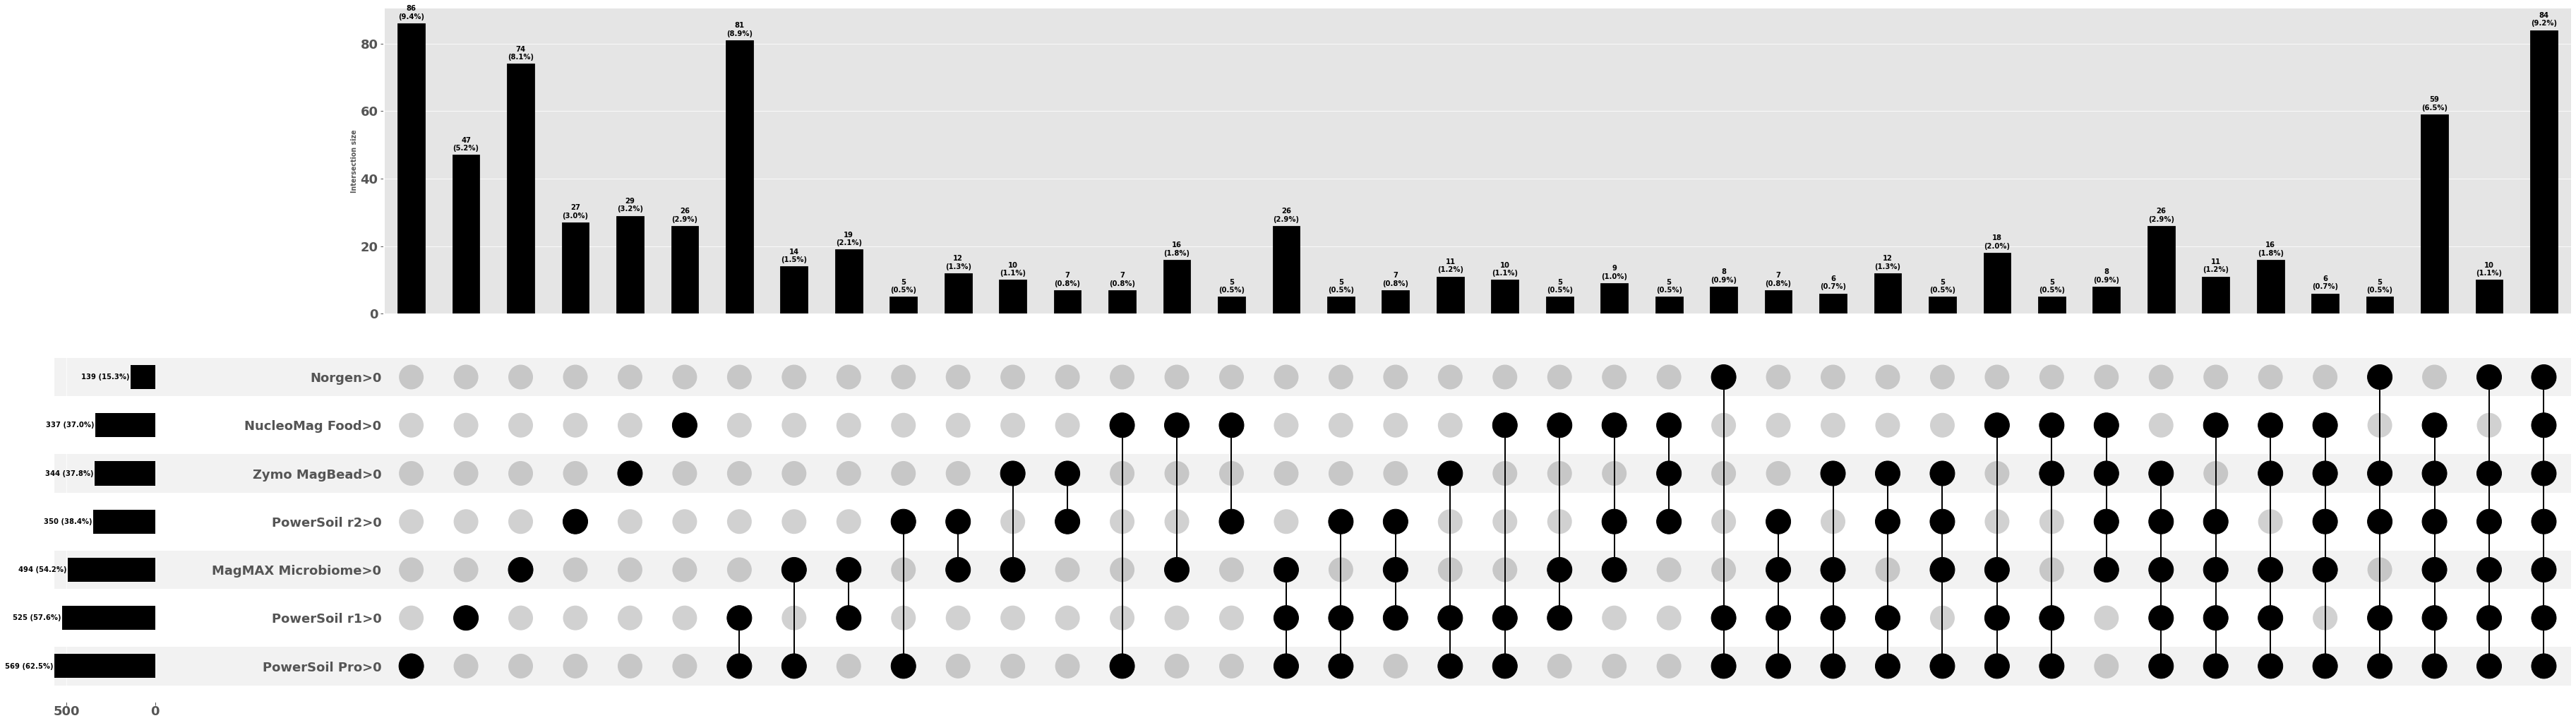

class


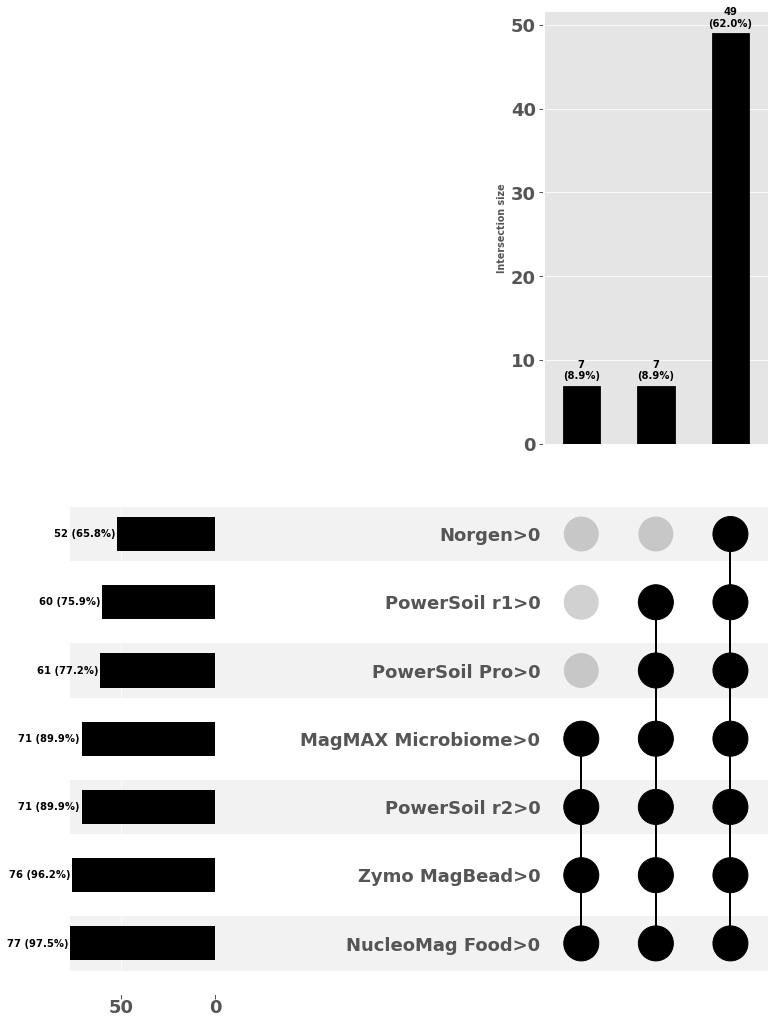

order


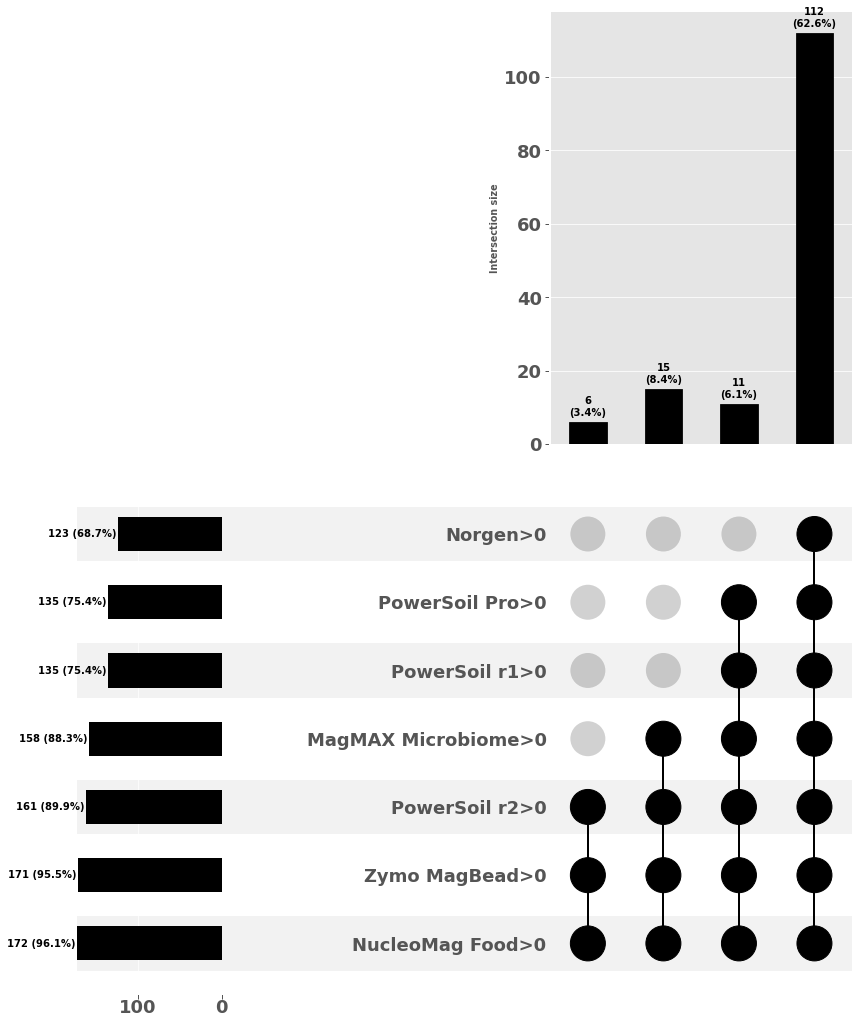

family


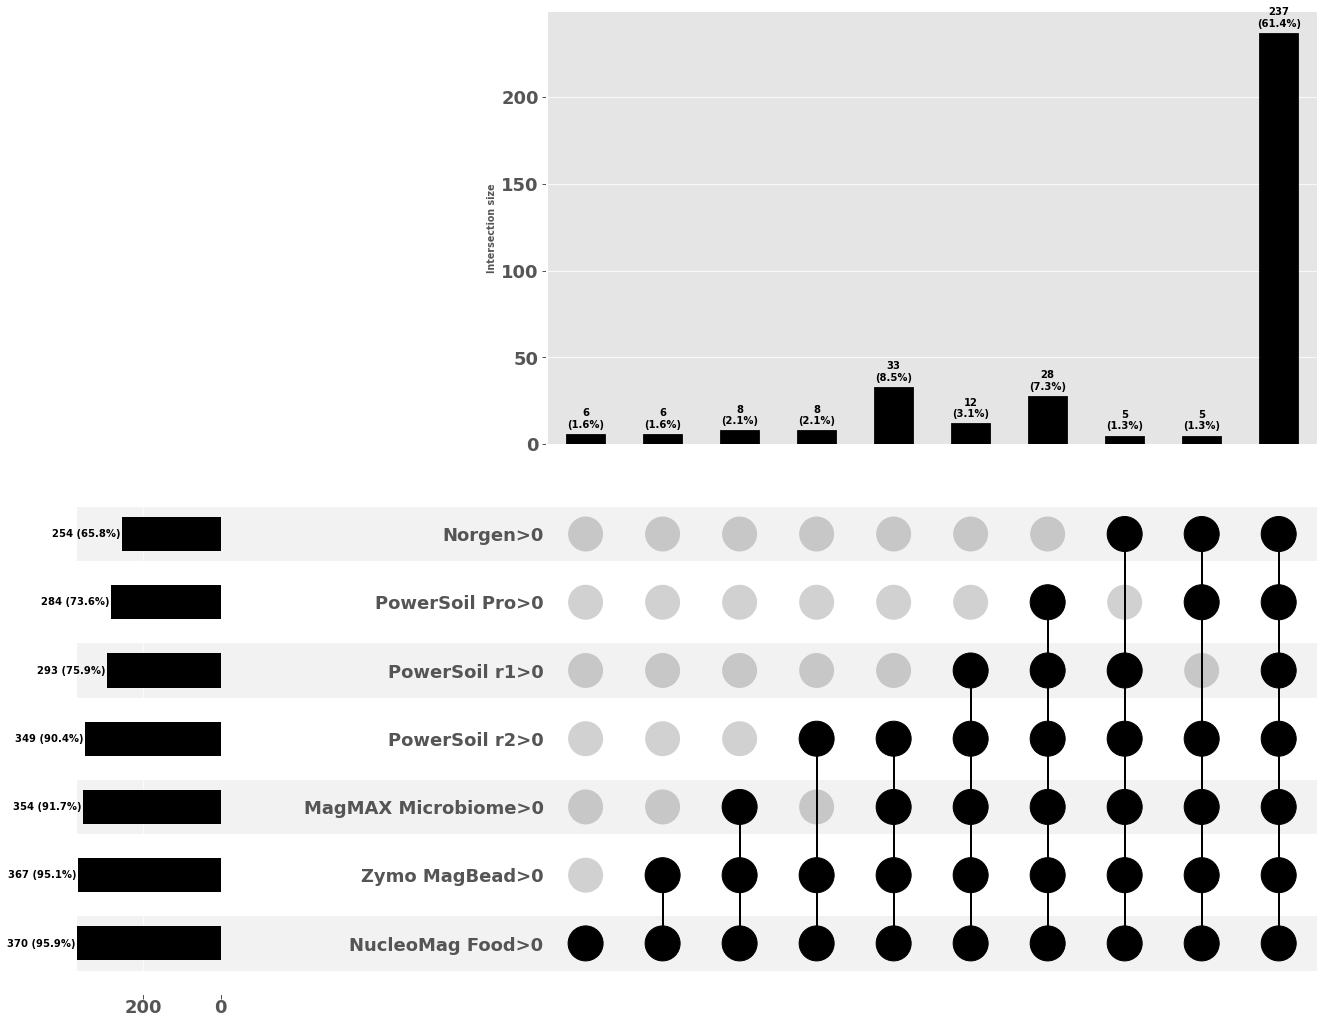

genus


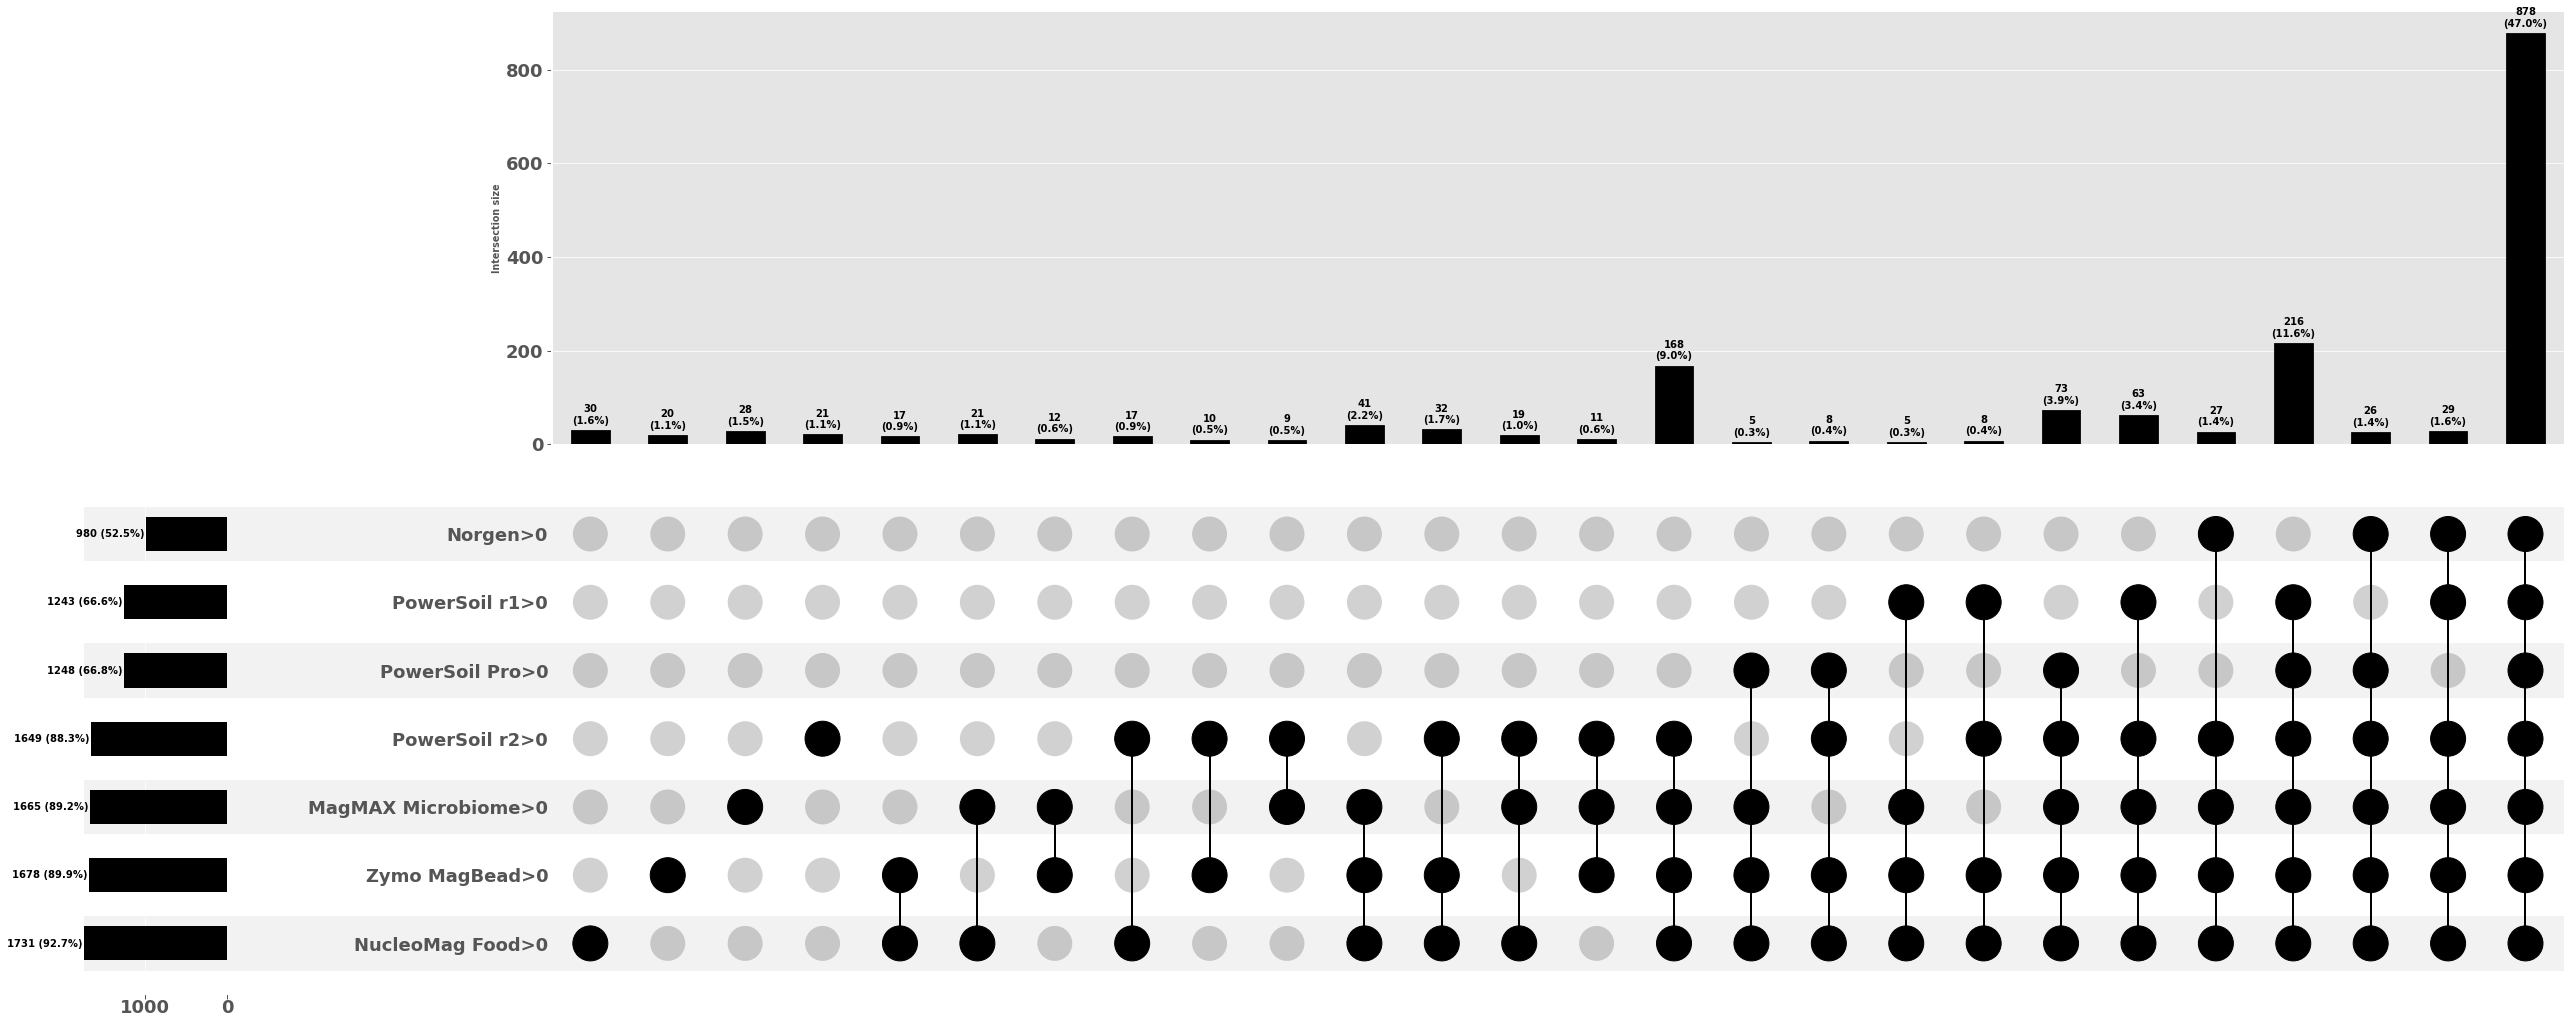

species


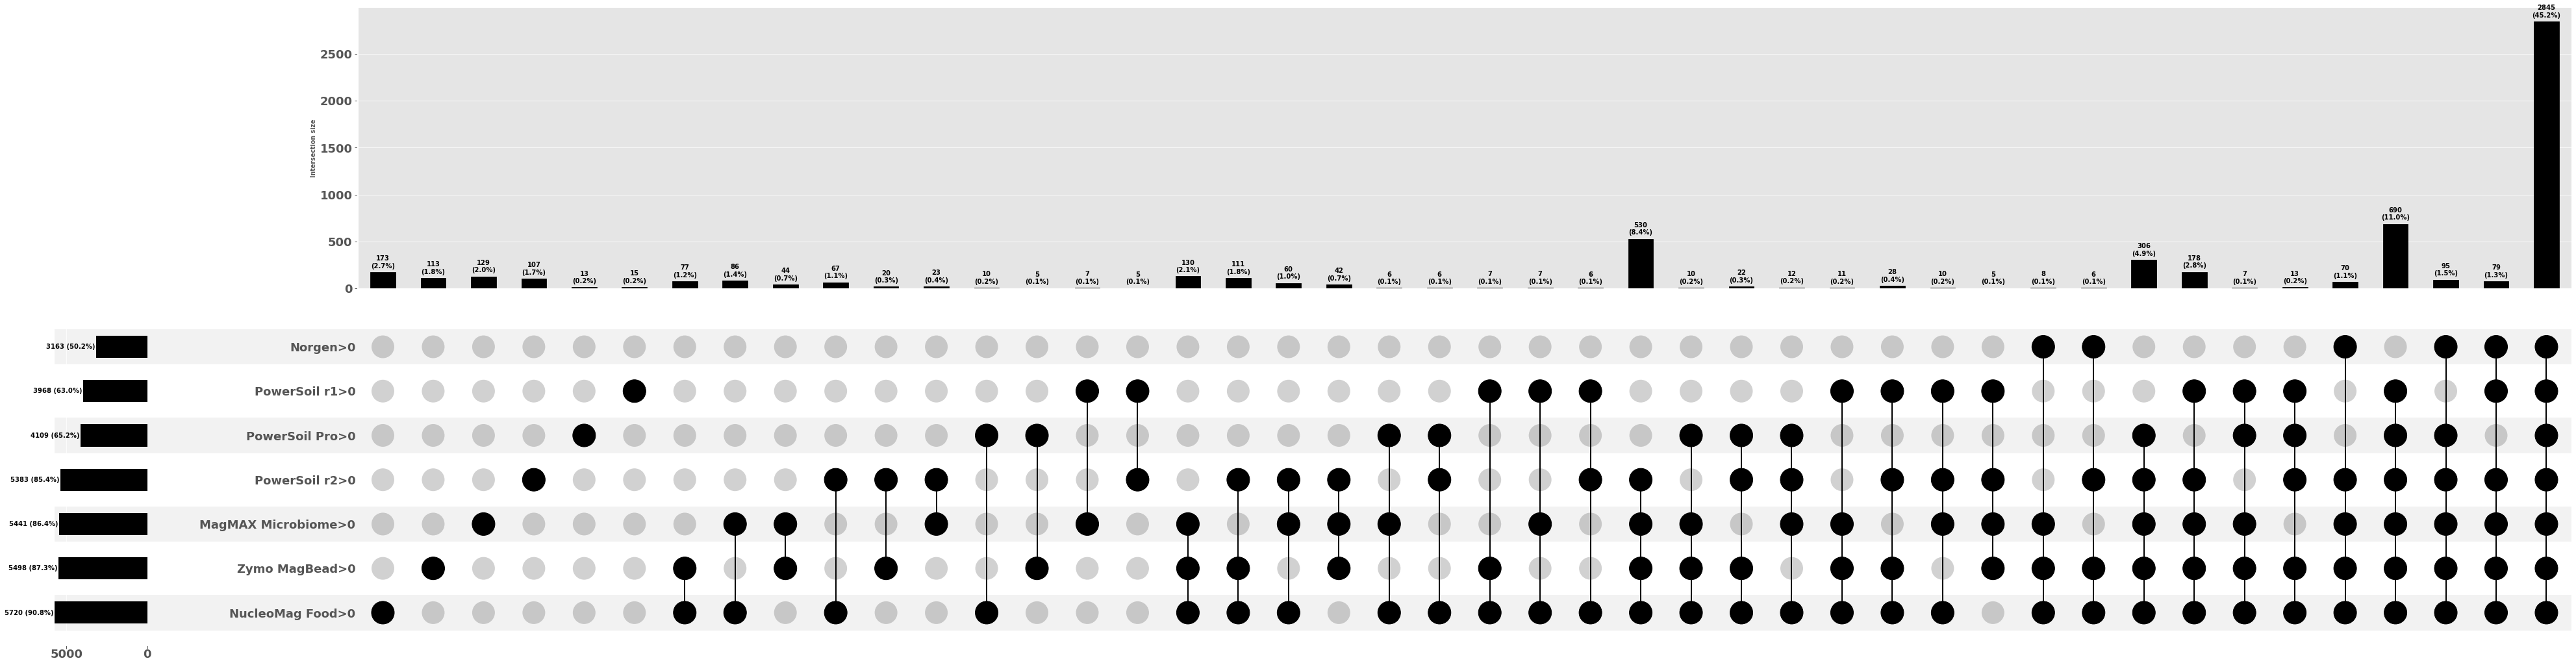

phylum


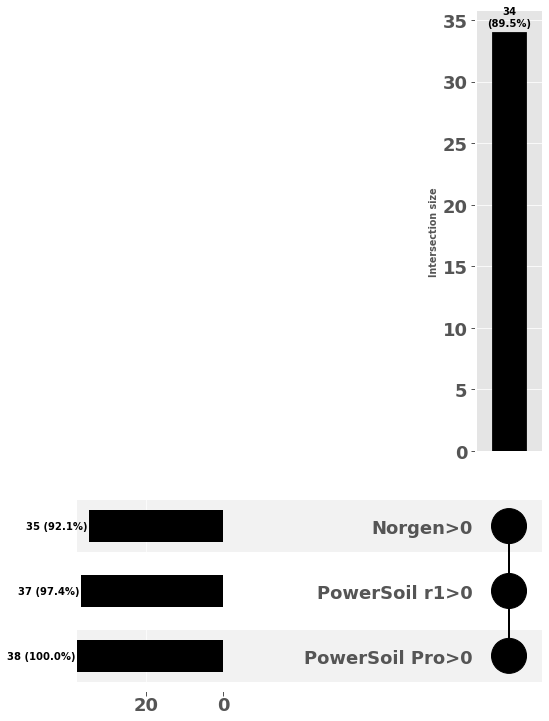

class


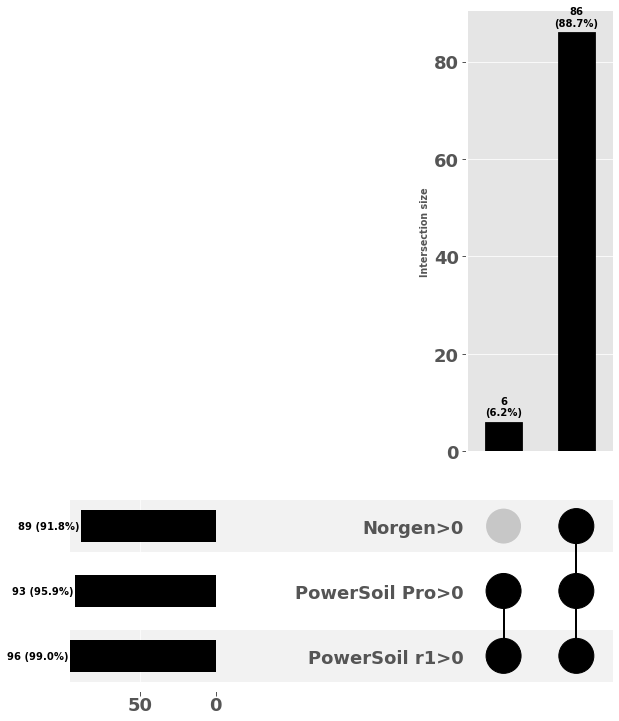

order


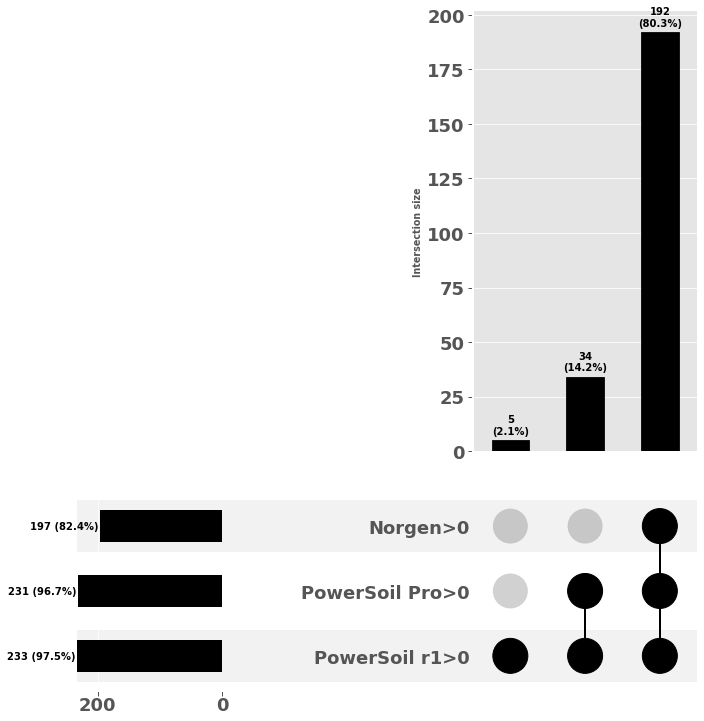

family


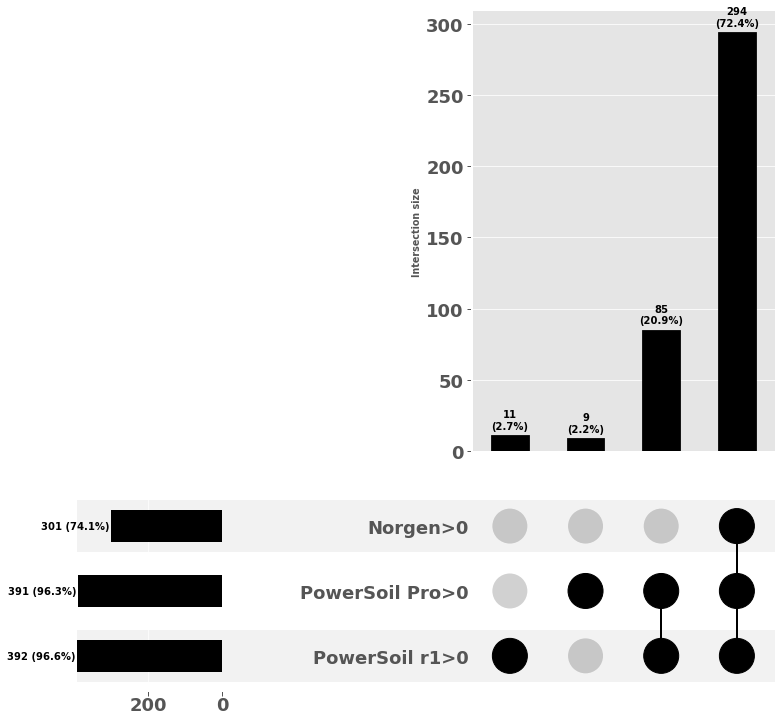

genus


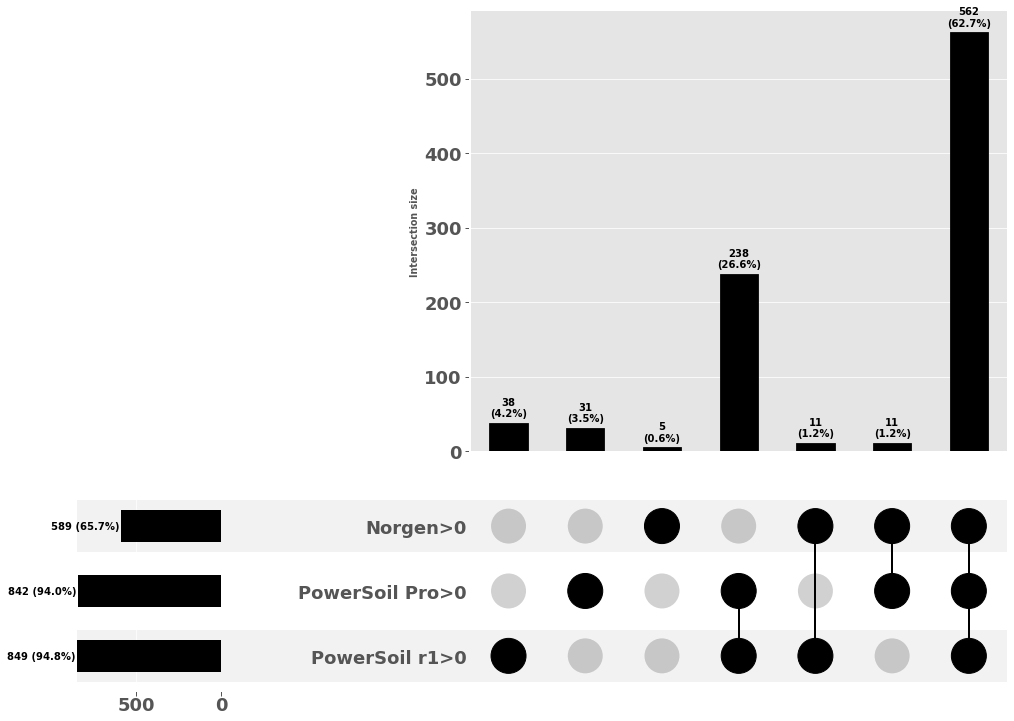

species


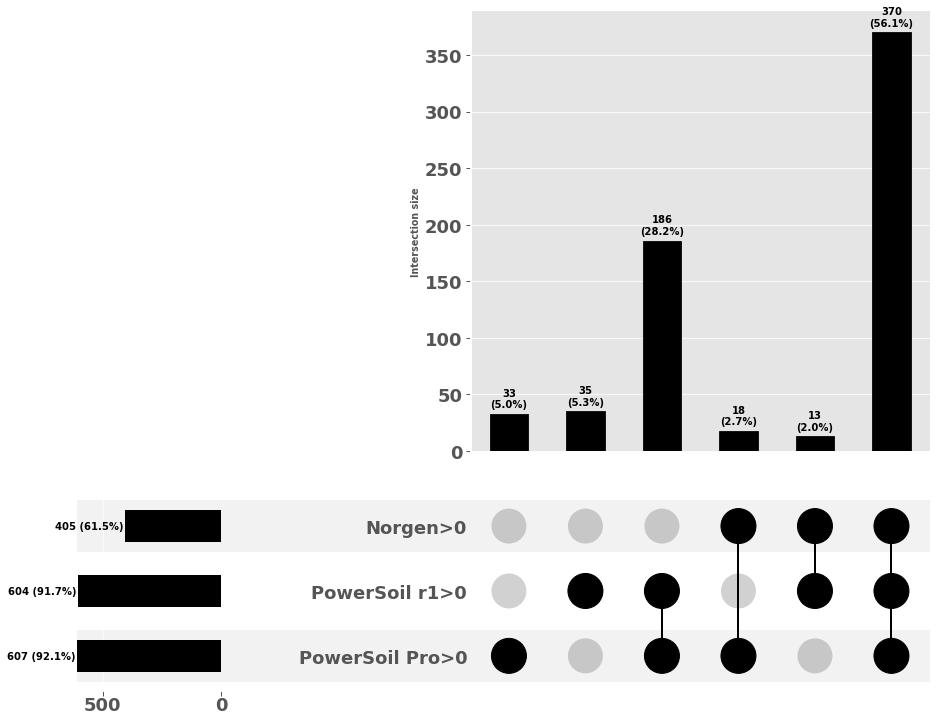

phylum


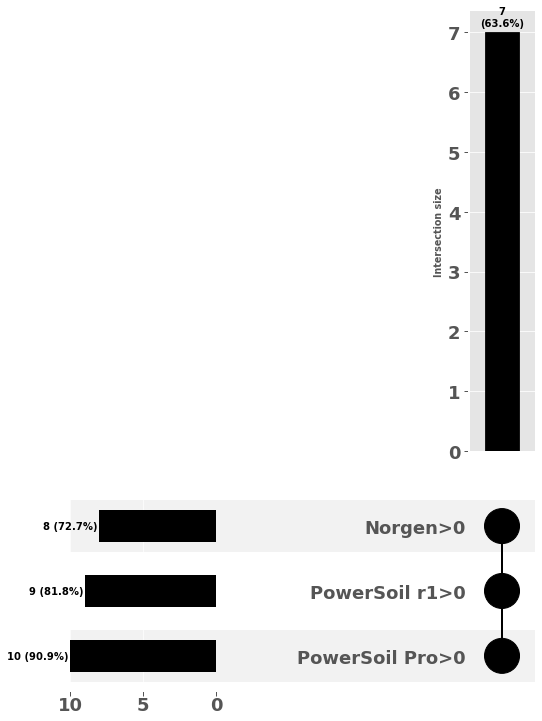

class


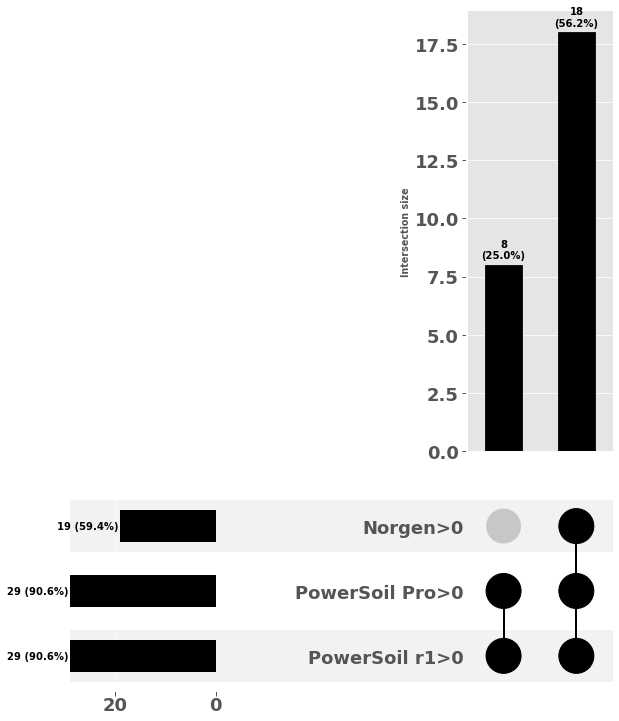

order


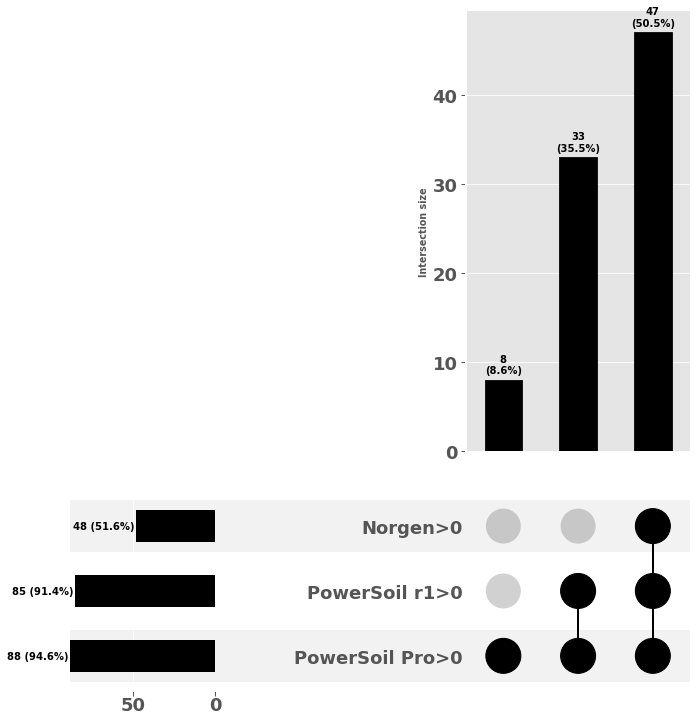

family


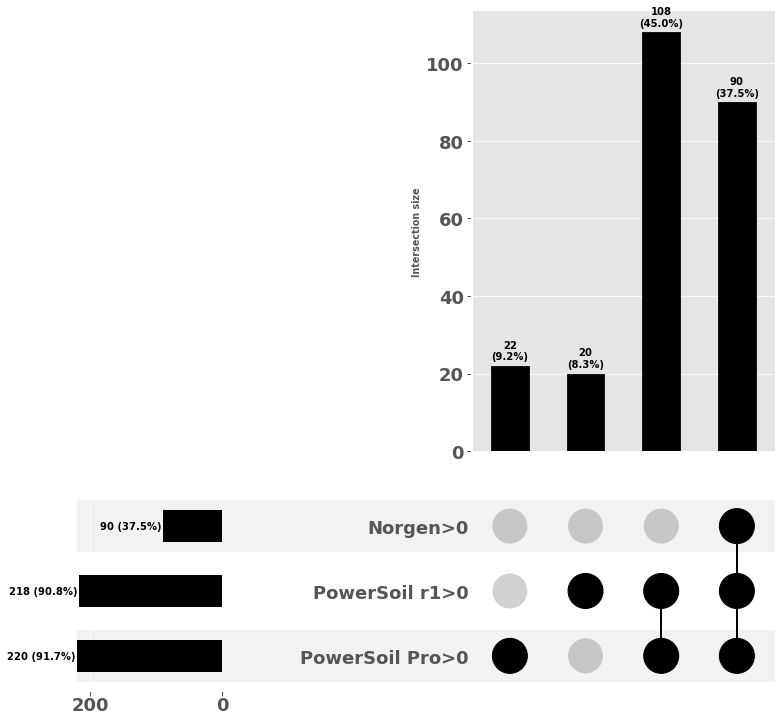

genus


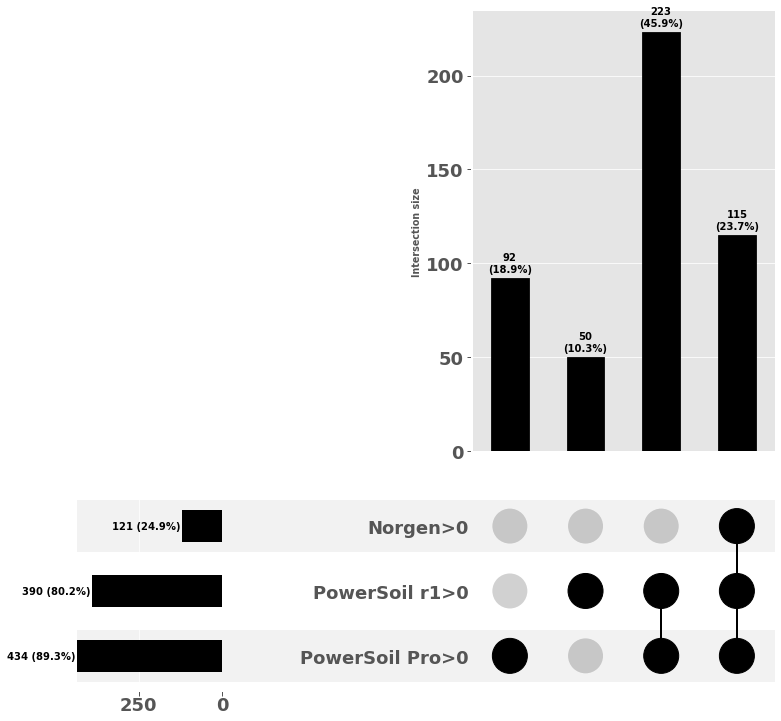

species


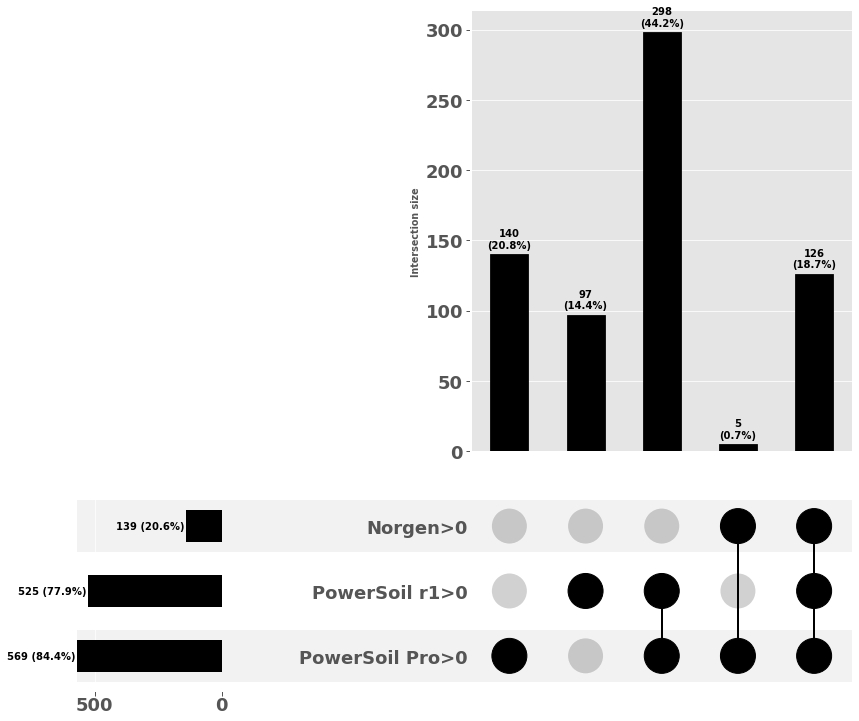

class


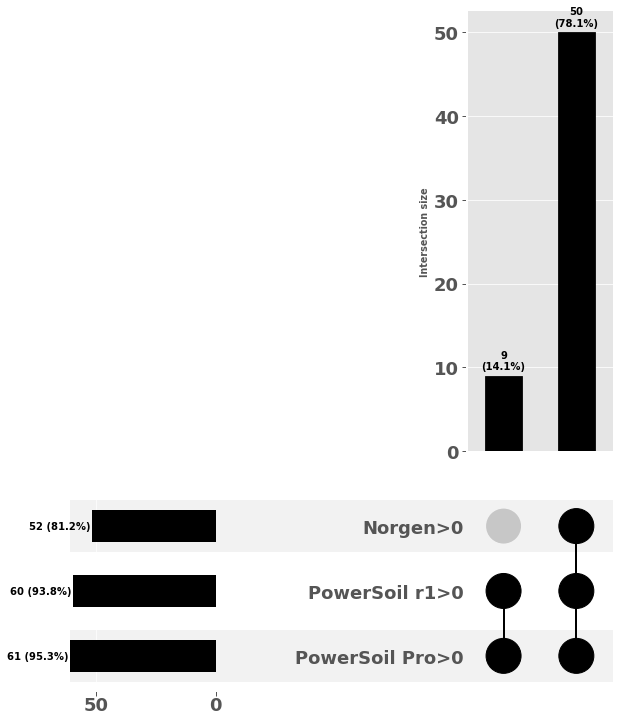

order


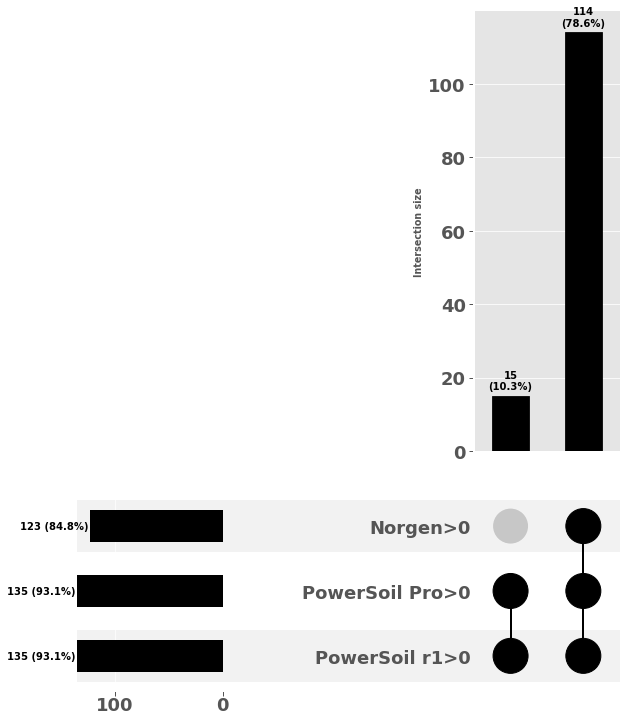

family


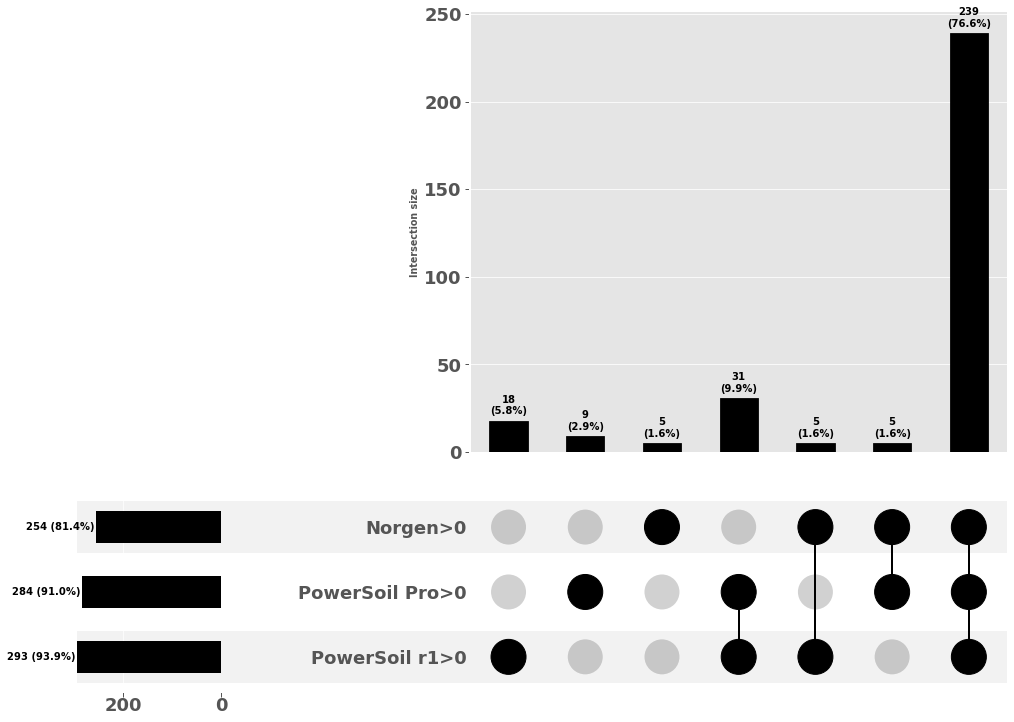

genus


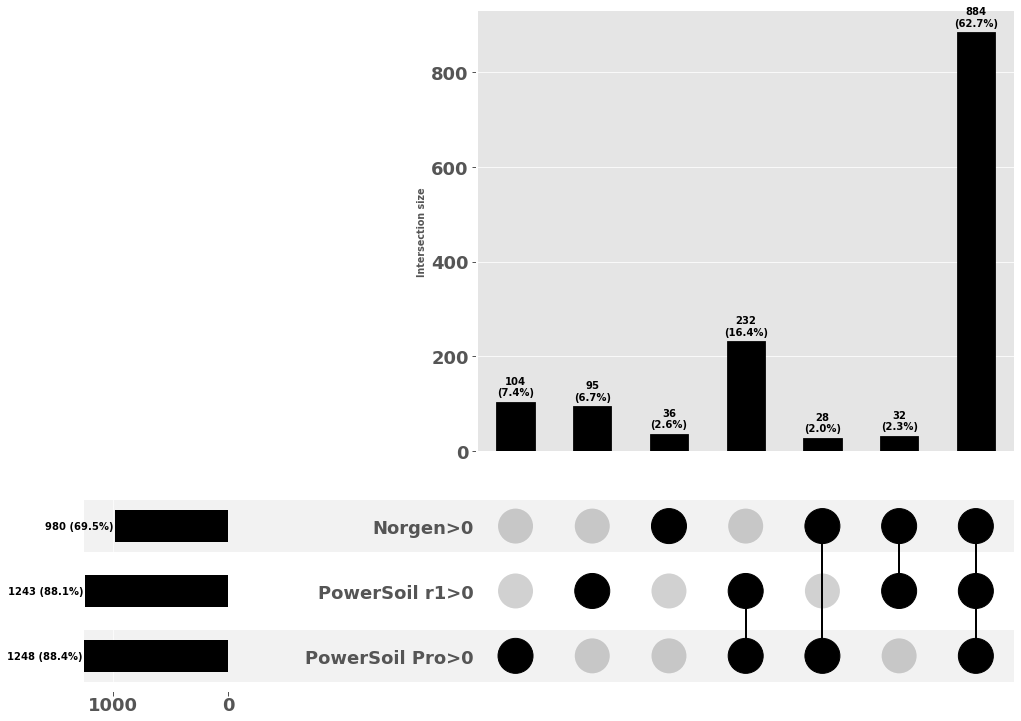

species


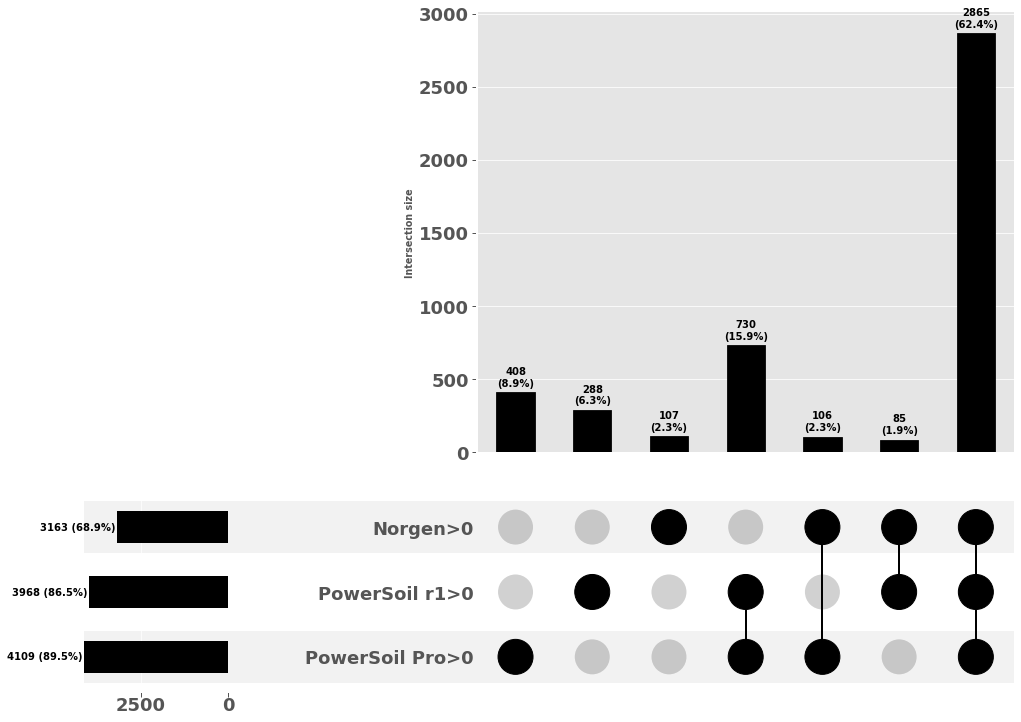

phylum


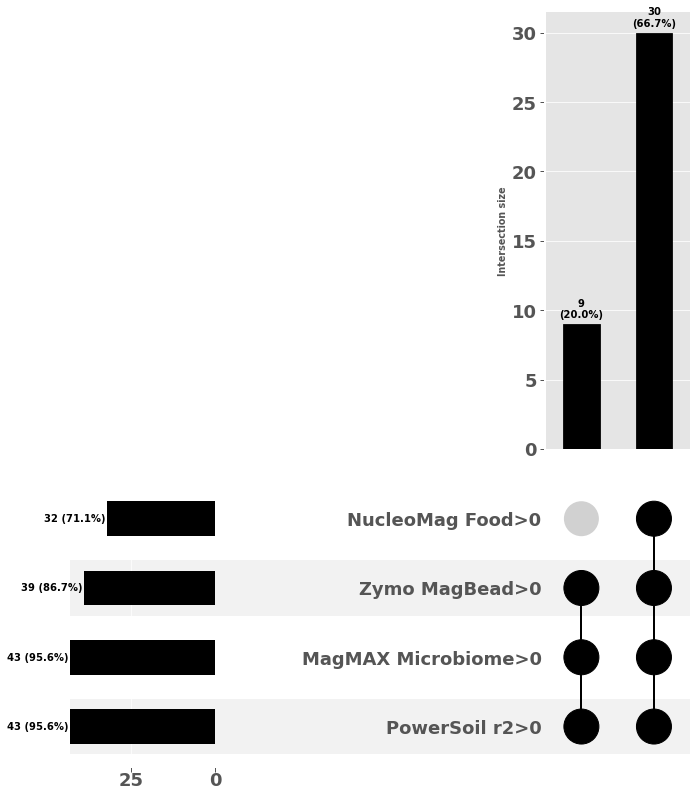

class


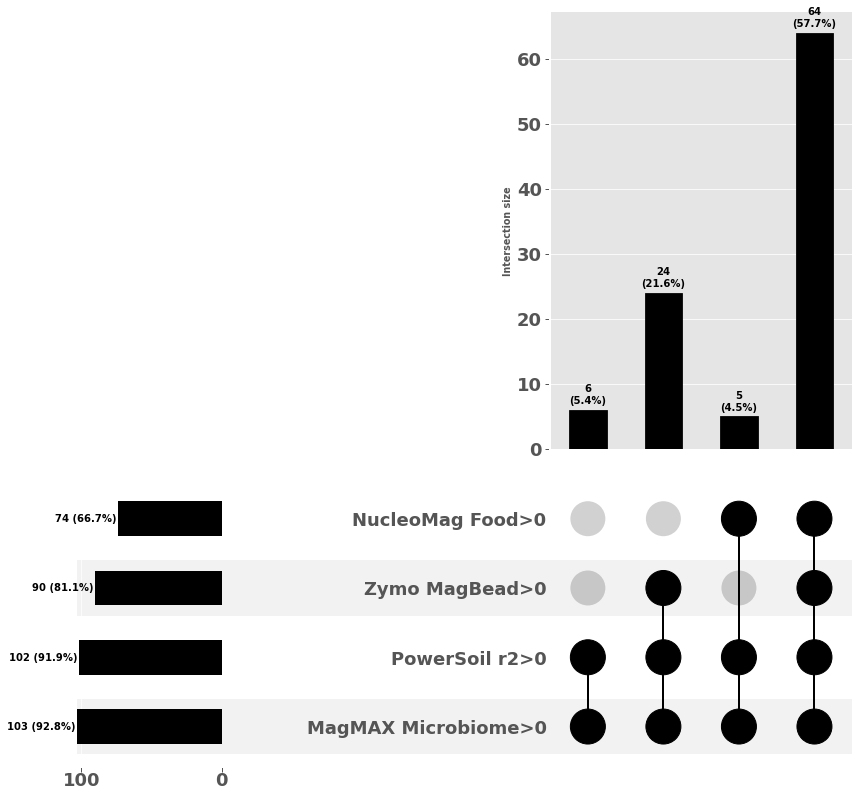

order


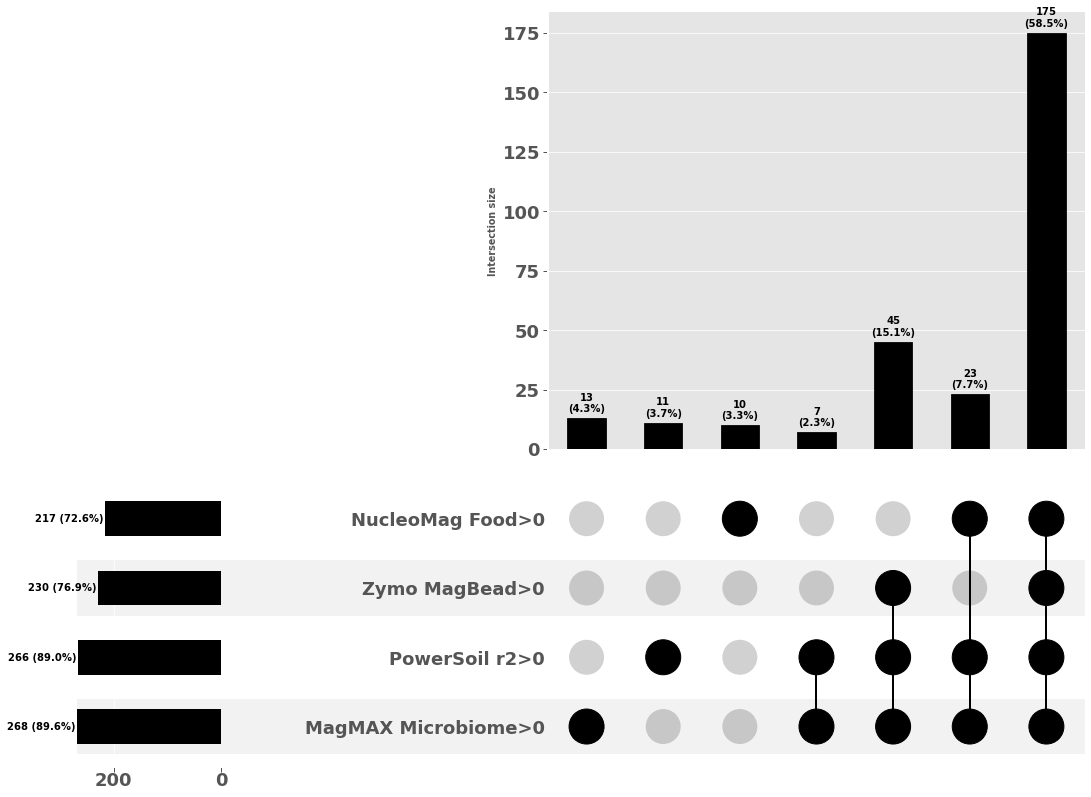

family


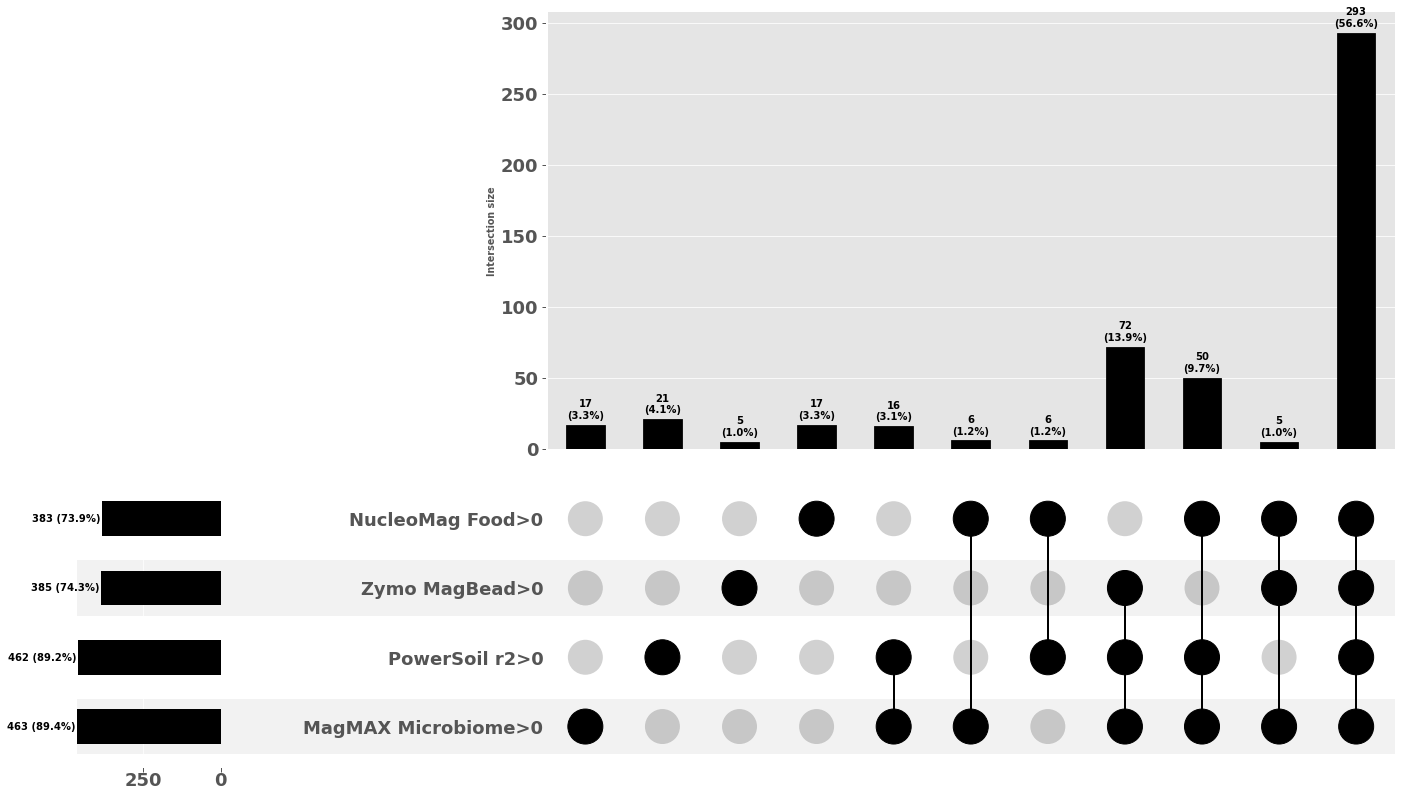

genus


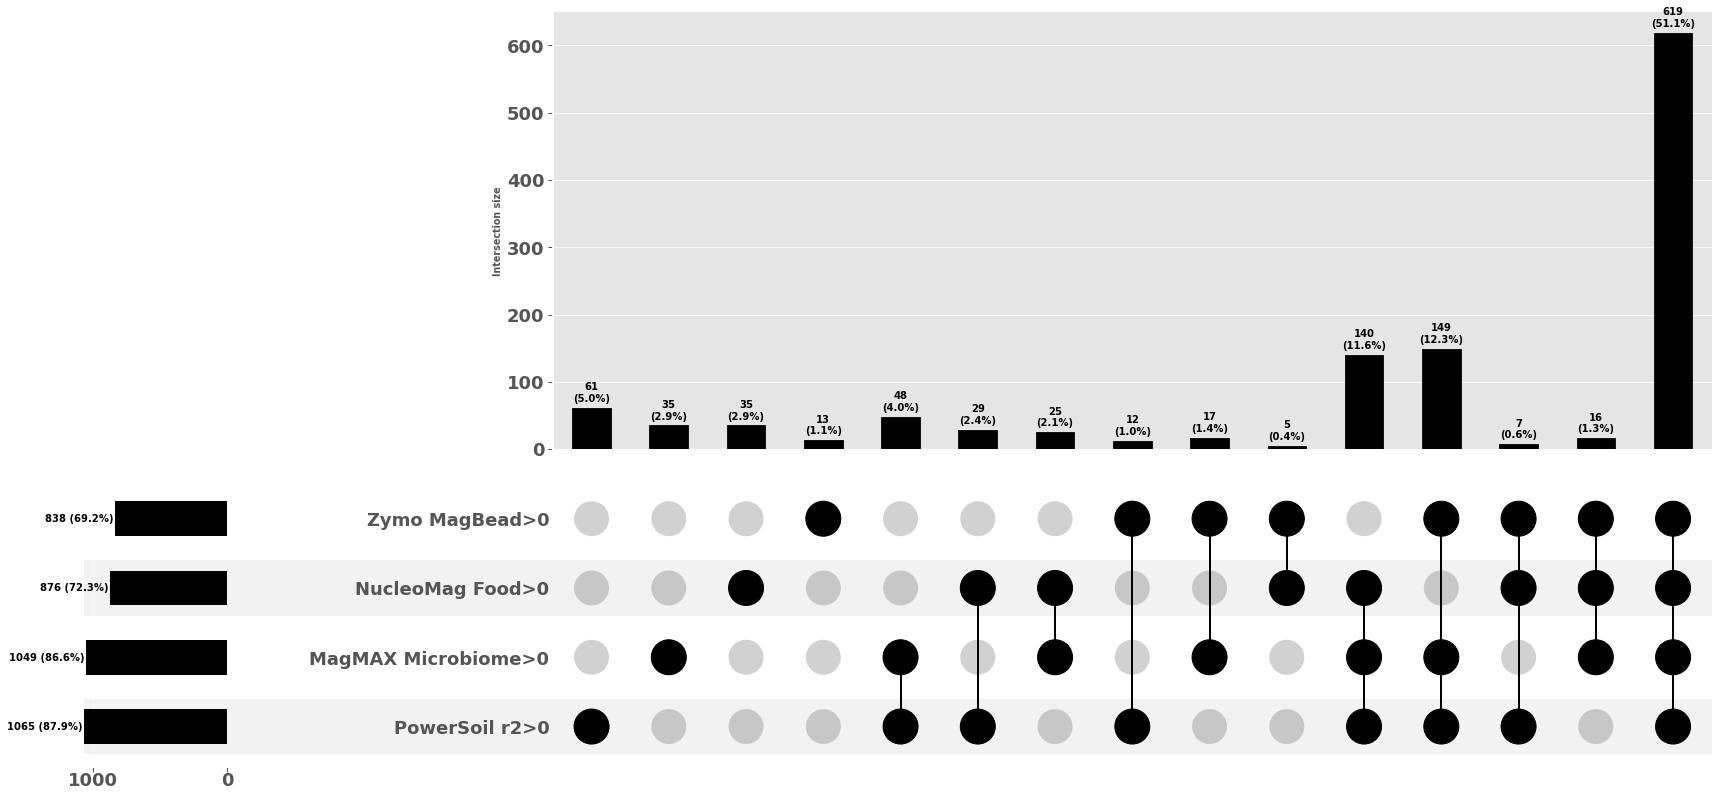

species


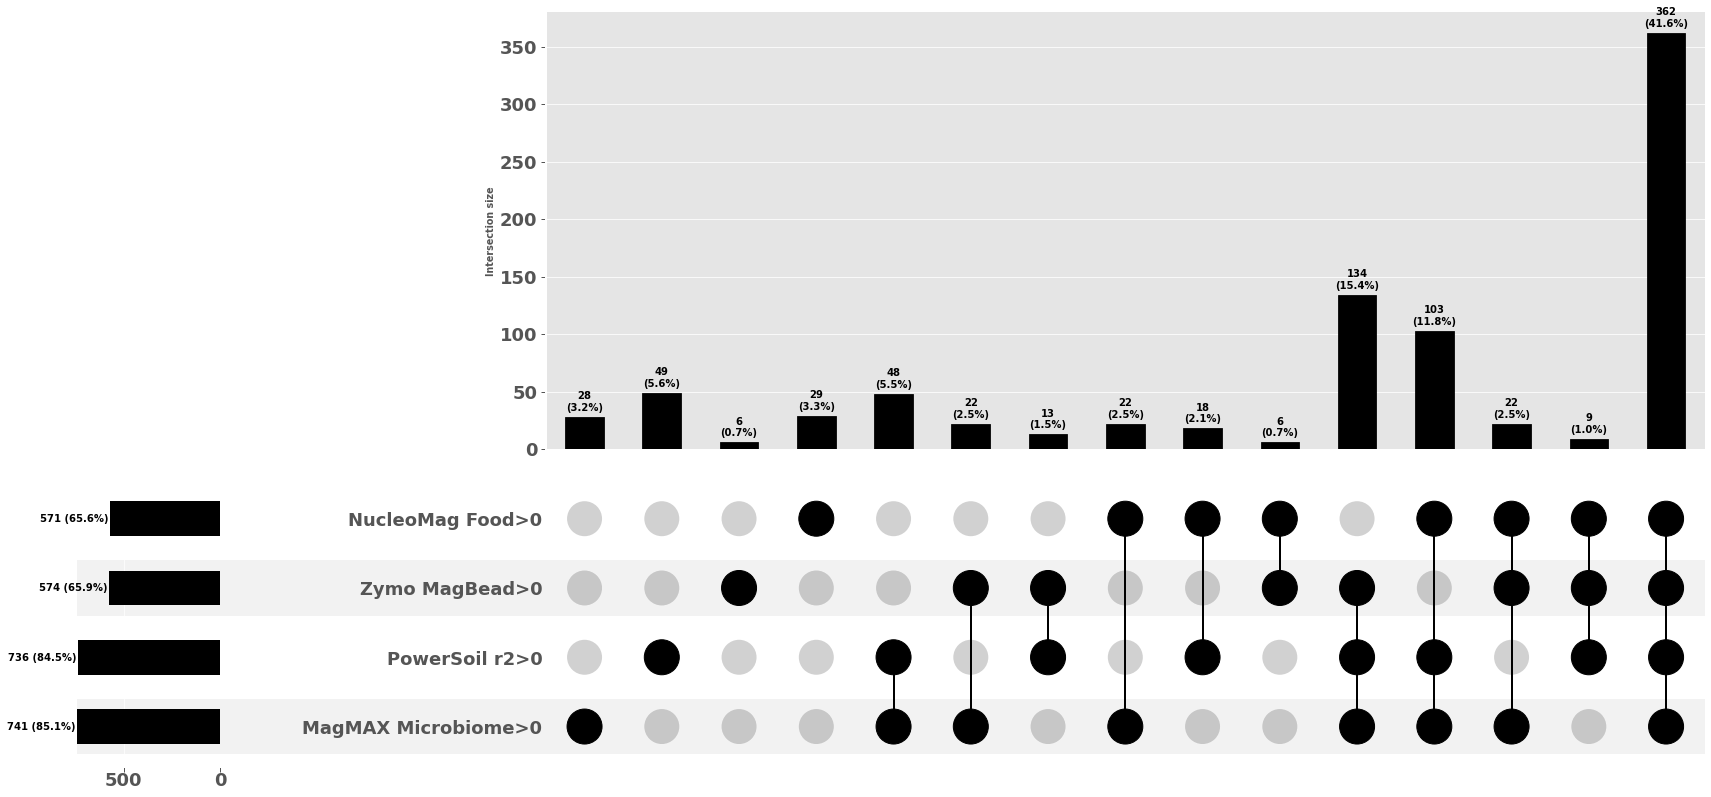

phylum


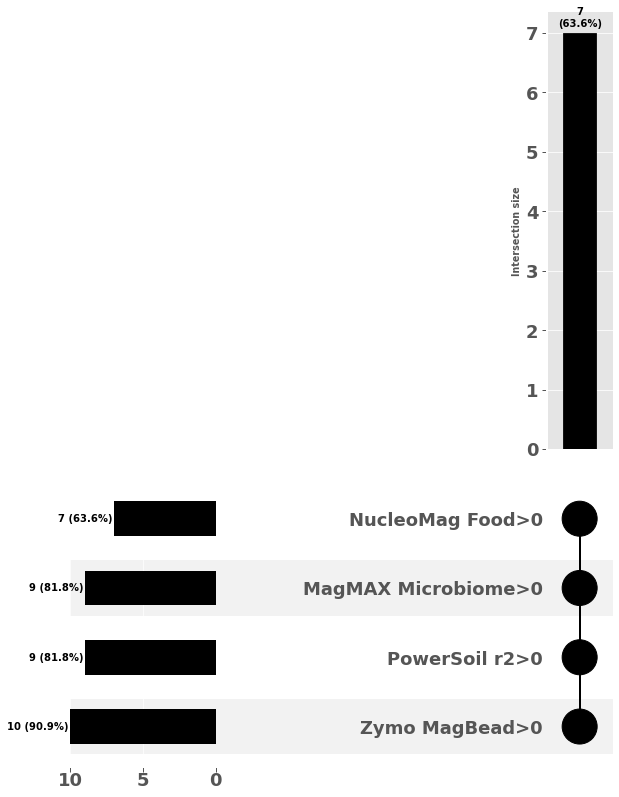

class


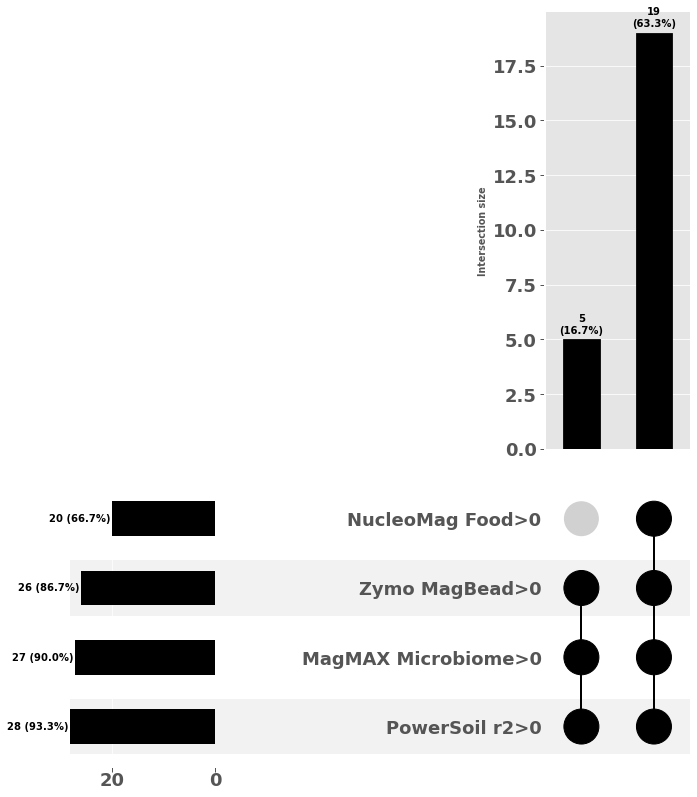

order


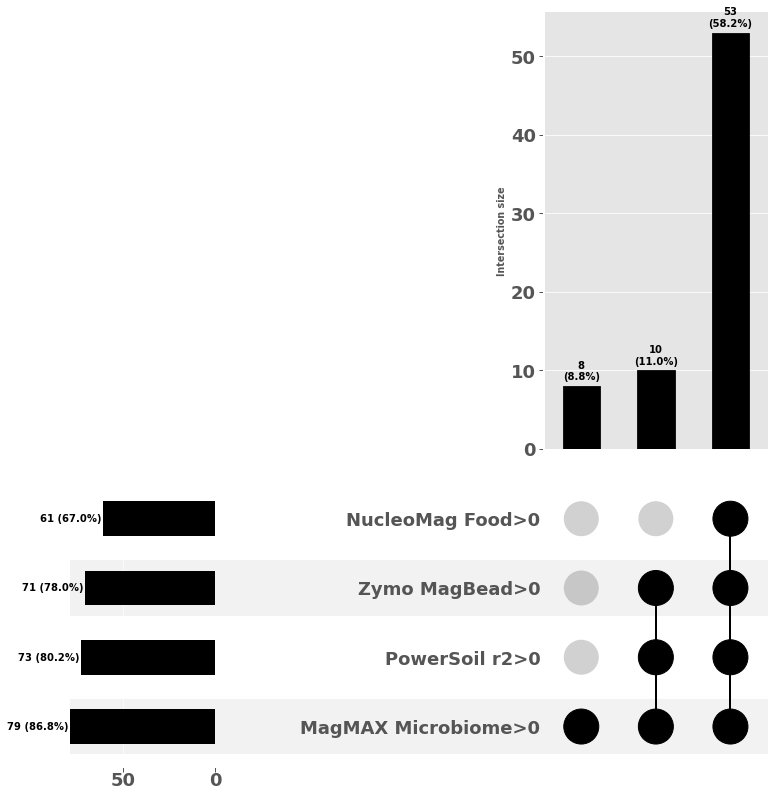

family


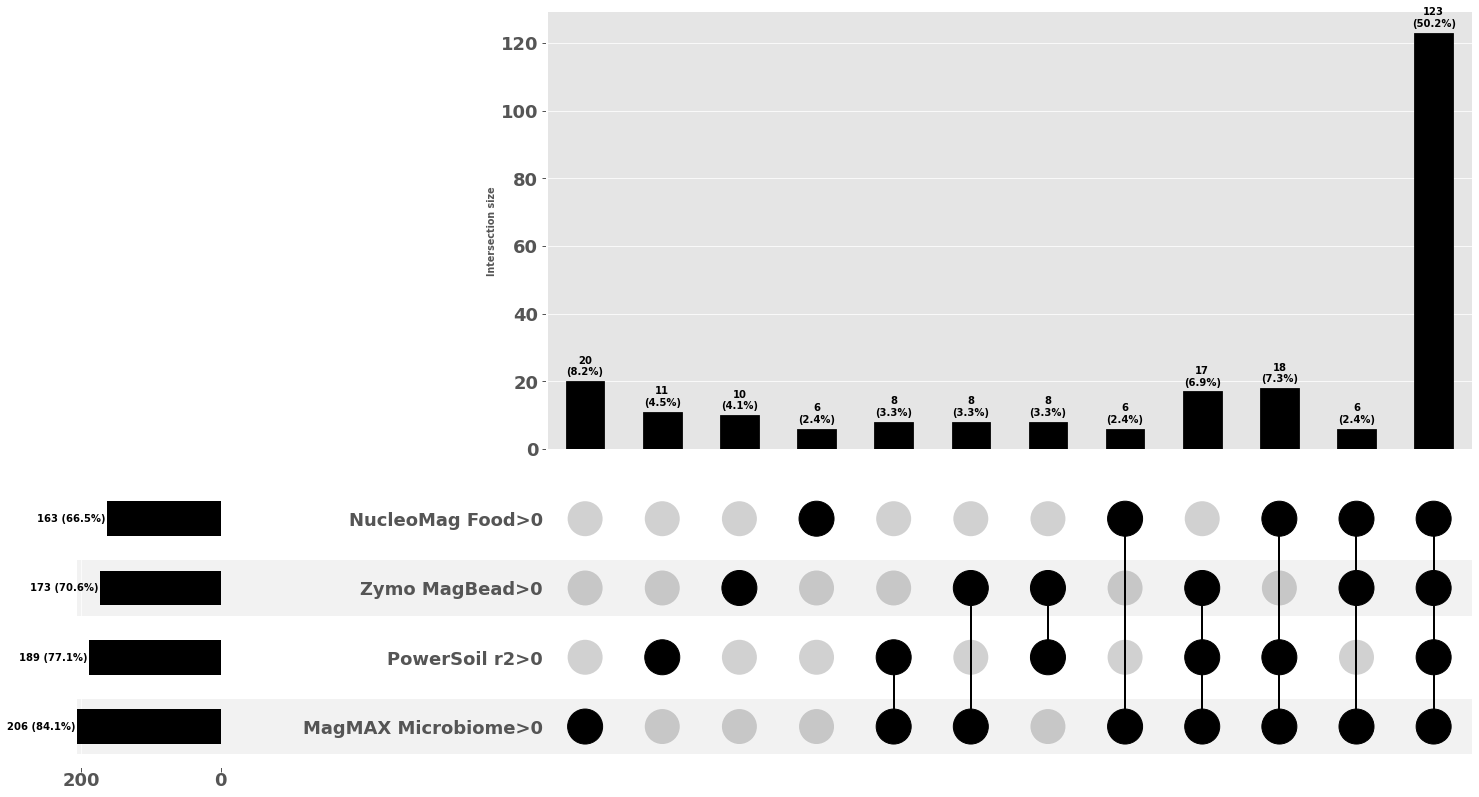

genus


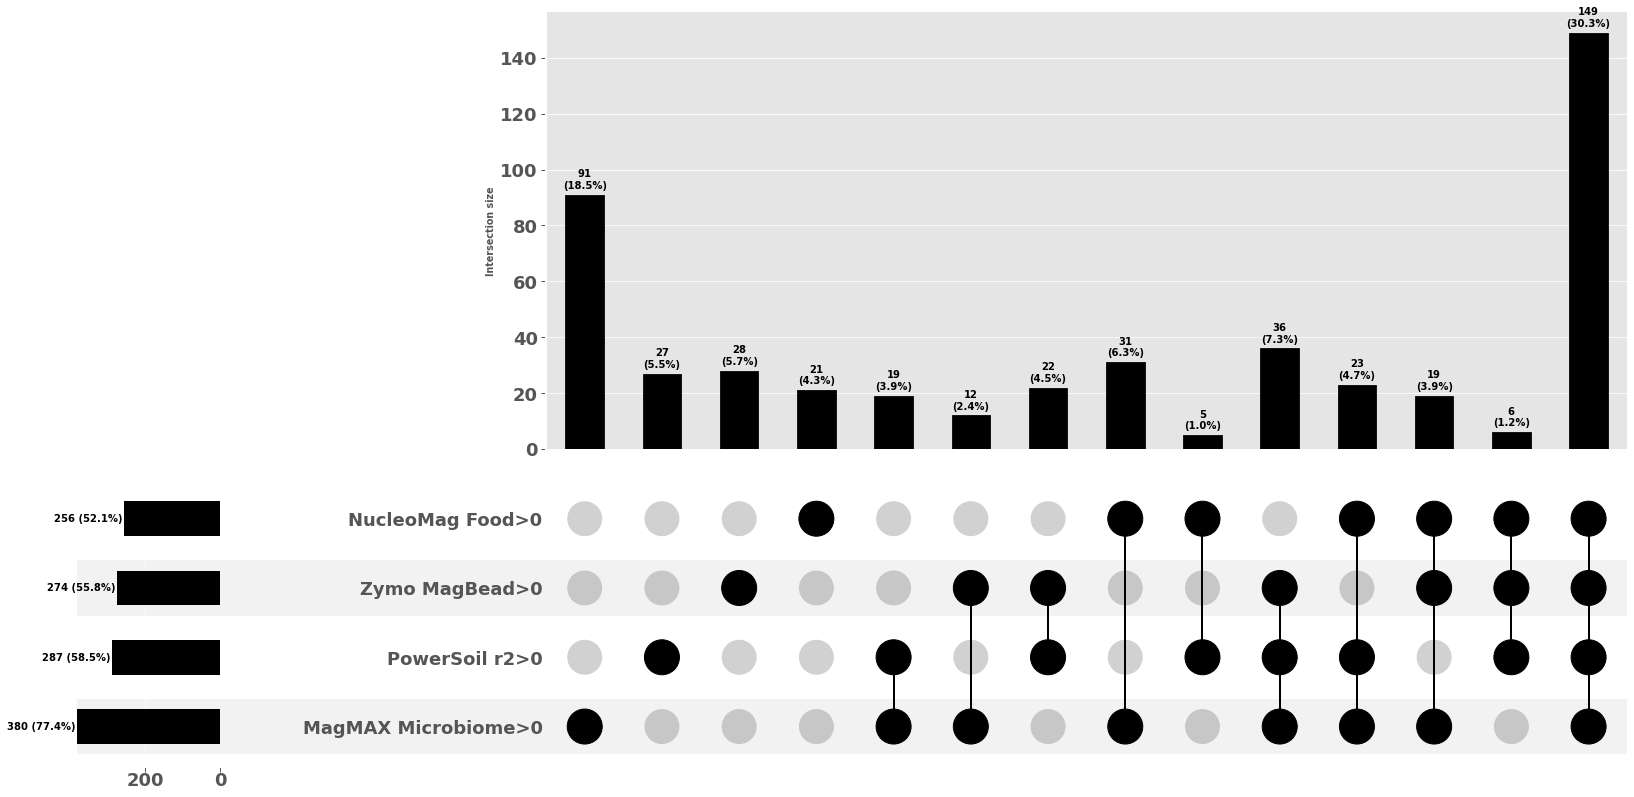

species


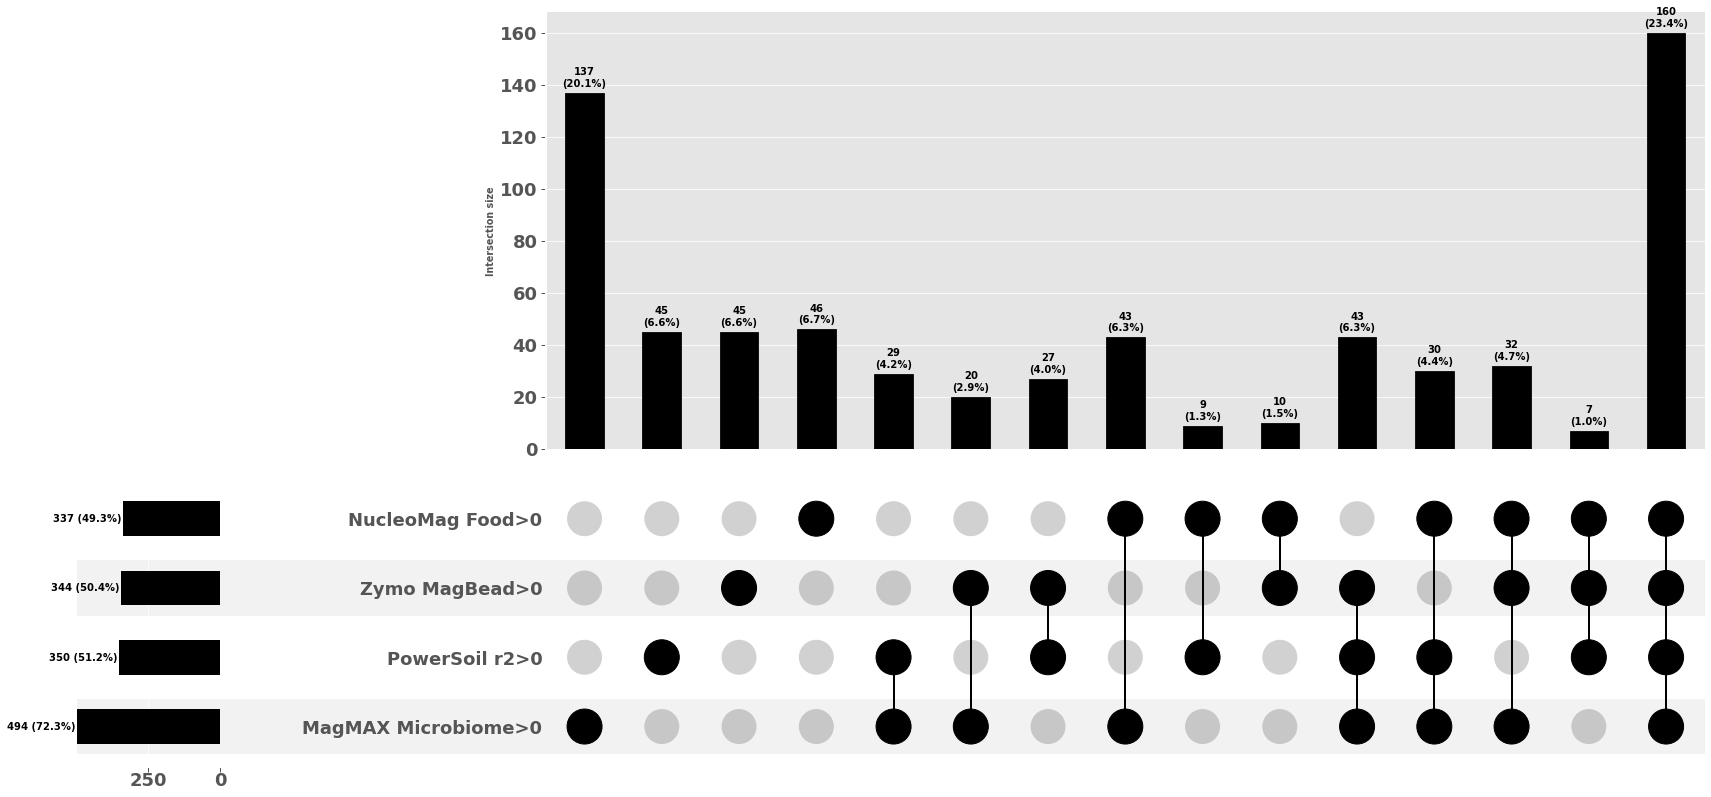

class


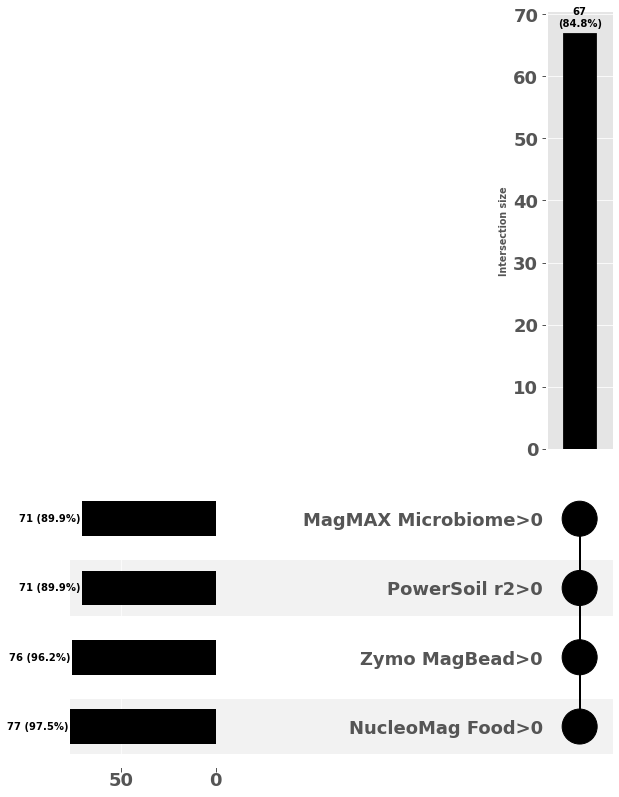

order


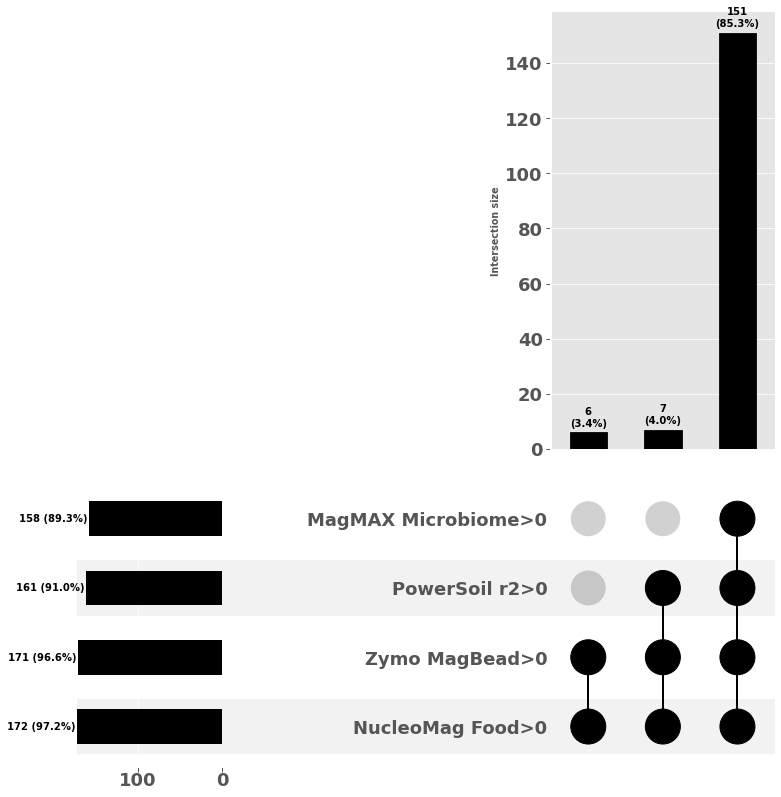

family


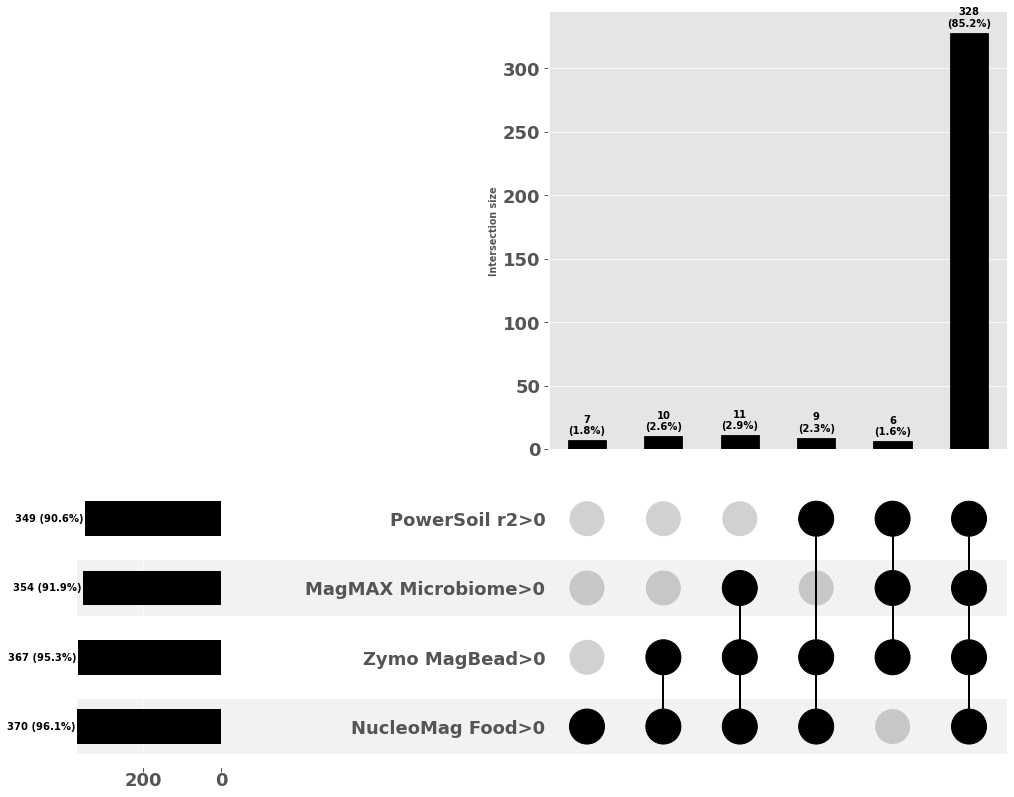

genus


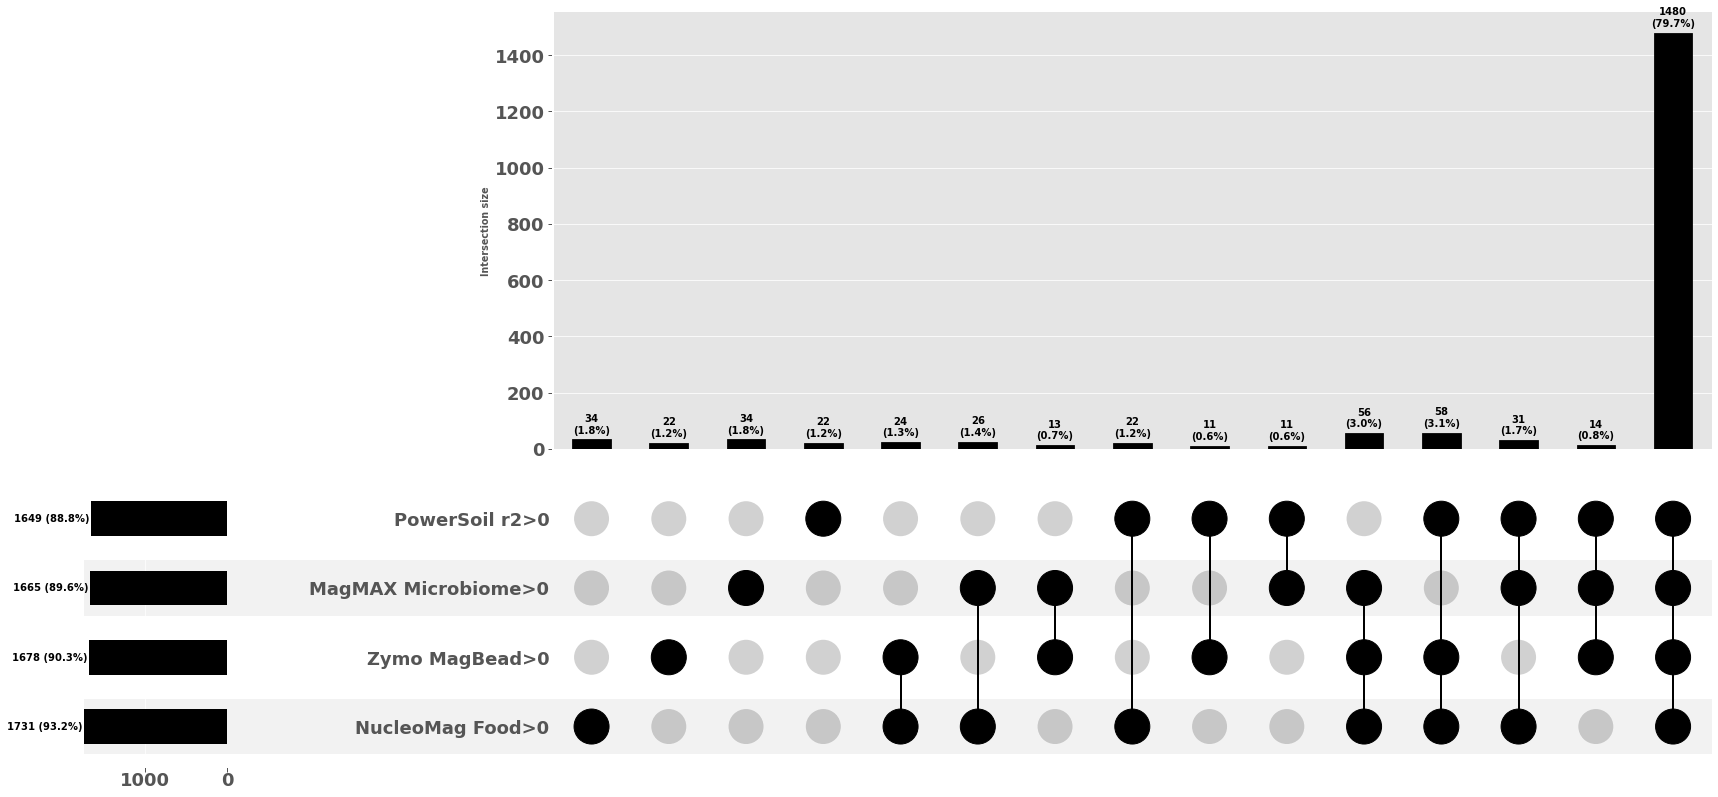

species


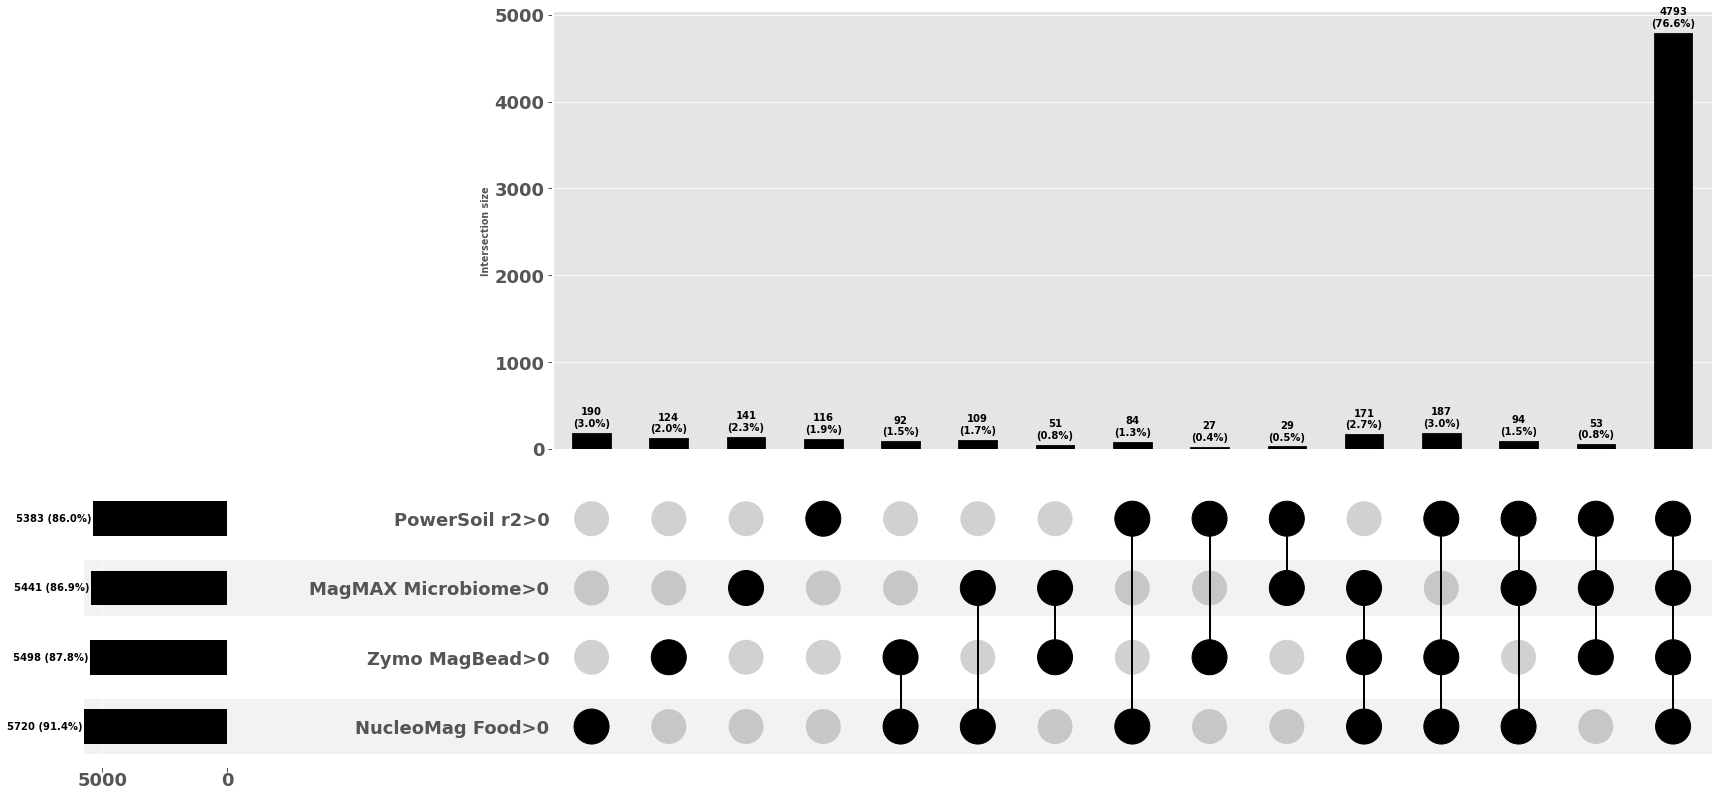

In [21]:
# Encode different protocols
# NOTE: If you only have one data layer, remove this loop, or add the same data to both protocols
protocols = {}
protocols['16S'] = ['/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/16S/10_filtered_data/dna_bothPS_16S_deblur_biom_lod_noChl_noMit_sepp_gg_noNTCs_noMock.qza',
                    '/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/sample_metadata/12201_metadata.txt',
                    '/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/16S/09_fragment_insertion/dna_all_16S_deblur_seqs_noChl_noMit_tree_gg.qza',
                    '/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/16S/06_taxonomy/dna_all_16S_deblur_seqs_taxonomy_silva138.qza']
protocols['ITS'] = ['/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/ITS/08_filtered_data/dna_bothPS_ITS_deblur_biom_lod_noNTCs_noMock.qza',
                    '/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/sample_metadata/12201_metadata.txt',
                    '/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/16S/09_fragment_insertion/dna_all_16S_deblur_seqs_noChl_noMit_tree_gg.qza',
                    '/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/ITS/06_taxonomy/dna_all_ITS_deblur_seqs_taxonomy_unite8.qza']
protocols['metagenomic'] = ['/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/shotgun/03_filtered_data/dna_bothPS_shotgun_woltka_wol_biom_noNTCs_noMock.qza',
                            '/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/sample_metadata/12201_metadata.txt',
                            '/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/shotgun/wol_tree.qza',
                            '/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/data/shotgun/wol_taxonomy.qza']

# Repeat for each level of a designated factor (i.e., if you want multiple upset plots)
# NOTE: 'variable' is the metadata column used to split the data into multiple analyses (i.e., upset plots). 
# The first line below selects and re-orders levels 1, 2, and 4 for inclusion, 
# but you can format this to include all or as many levels of the varaible that you prefer.
# If you only want one upset plot comparing all of the data, remove this loop
for extraction_round, variable_  in {'all':['round_1', 'round_2'],
                           'round_1':['round_1'],'round_2':['round_2']}.items():
    # Repeat for both protocols
    for protocol, (table, metadata, tree, taxonomy) in protocols.items():
        # Import data
        table = q2.Artifact.load(table).view(biom.Table)
        metadata = q2.Metadata.load(metadata).to_dataframe()
        # The first line below creates a new metadata variable out of two existing ones.
        # If you already have the variable you want to use to compare groups, remove the first line below,
        # and replace 'variable_1_and_2' farther below with your variable of interest
        metadata = metadata[metadata.extraction_round.isin(variable_)]
        # Match tables
        shared_ = set(table.ids()) & set(metadata.index)
        table = table.filter(shared_)
        metadata = metadata.reindex(shared_)

        if 'qza' not in tree:
            tree = q2.Artifact.import_data('Phylogeny[Rooted]', tree)
        else:
            tree = q2.Artifact.load(tree)

        if 'qza' not in taxonomy:
            taxonomy = q2.Metadata.load(taxonomy).to_dataframe()
        else:
            taxonomy = q2.Artifact.load(taxonomy).view(q2.Metadata).to_dataframe()
        taxonomy = add_taxsplit(taxonomy) # Split by taxonomic level
        taxonomy.reindex(table.ids('observation'))

        #metadata['extraction_kit_round'] = metadata['extraction_kit_round'].astype('category')
        #metadata['extraction_kit_round'].cat.reorder_categories(['PowerSoil r1',
        #                                                             'PowerSoil Pro',
        #                                                             'Norgen',
        #                                                             'PowerSoil r2',
        #                                                             'MagMAX Microbiome',
        #                                                             'NucleoMag Food',
        #                                                             'Zymo MagBead'],
        #                                                            inplace=True)

        total_kits = []
        for kit_, mfdf in metadata.groupby('extraction_kit_round'):
            # Get all taxa for this level
            psbt = table.copy()
            psbt = psbt.filter(mfdf.index)
            keep_ = psbt.ids('observation')[psbt.sum('observation') > 0]
            psbt = psbt.filter(keep_, axis='observation')
            psbt = pd.DataFrame(psbt.sum(axis='observation'),
                                psbt.ids('observation'),
                                [kit_])
            total_kits.append(psbt)
        # Combine totals
        totaldf = pd.concat(total_kits, axis=1).fillna(0)
        totaldf.head(5)

        # Format plotting for each level
        formatted_levels = {}
        for level_ in taxonomy.columns[3:]:
            tax_ = taxonomy.loc[totaldf.index, level_].copy().dropna()
            totaldf_tax = totaldf.loc[tax_.index, :].copy()
            totaldf_tax[level_] = tax_.loc[totaldf_tax.index,]
            totaldf_tax = totaldf_tax.groupby(level_).sum()
            totaldf_tax = format_uplot(totaldf_tax)
            formatted_levels[level_] = totaldf_tax.copy()

        for level_, pltdf_ in formatted_levels.items():
            print(level_)
            # UpSet plot - Filters associations with < 5 unique taxa (min_subset_size)
            fig = plt.figure(figsize=(12,10))
            upset = UpSet(pltdf_, 
                          orientation = 'horizontal',
                          sort_by = 'degree',
                          sort_categories_by = 'cardinality',
                          subset_size='count',
                          min_subset_size = 5,
                          element_size = 100,
                          #facecolor='gray',
                          show_counts=True,
                          show_percentages = True)
            #upset.add_catplot(value='median_value', kind='strip', color='blue')
            #upset.add_catplot(value='AGE', kind='strip', color='black')
            upset.plot(fig=fig)
            # Save the figure to file
            plt.savefig('/Users/Justin/Mycelium/UCSD/00_Knight_Lab/03_Extraction_test_12201/round_02/results/upset_plots_horizontal_min5/protocol-%s_variable-%s_upset-%s.pdf' % (protocol, extraction_round, level_),dpi=600, 
                        bbox_inches='tight',
                        facecolor=fig.get_facecolor(), 
                        edgecolor='none')

            plt.show()
